<a href="https://colab.research.google.com/github/teozoia/gkmeans/blob/master/MatteoZoia_GPUComputing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#gkmeans
_Matteo Zoia, 941976_

_Implementazione dell'algoritmo di cluster k-means su GPU tramite il linguaggio CUDA C @ Unimi (progetto di GPU computing)._

##Introduzione
In questa relazione vengono presentate due implementazioni  per GPU dell'algoritmo di clustering k-means. Lo scopo dell'elaborato é descrivere i passaggi logici per la stesura degli algoritmi e mostrare lo speedup ottenuto attraverso attivitá di profiling e benchmark. 
Il principale riferimento per questa implementazione é  _"Speeding up k-means algorithm by GPUs"_, articolo scientifico che propone due versioni ottimizzate:
* versione per dataset con bassa dimensionalitá (ottimizzata tramite l'uso di registri)
* versione per dataset con alta dimensionalitá (basata sulla moltiplicazione matriciale)

Al termine della trattazione dei due algoritmi suggeriti, viene proposta ed analizzata una terza soluzione che contiene diverse ottimizzazioni, atte a migliorare l'implementazione basata su dataset con alta dimensionalitá.

## Design di (g)kmeans su GPU
K-means é un algoritmo di clustering che, dato un dataset di $N$ punti $\{p_1, p_2, ... , p_n\}$ in uno spazio di dimensione $D$, lo partiziona in $K$, cluster in modo che per ogni cluster sia minimizzata la distanza tra il centroide e ogni punto in esso contenuto.

L'algoritmo puó essere cosí descritto: assegnati i centroidi iniziali (attraverso una tecnica scelta), per ogni punto viene computata la distanza euclidea con ogni centroide e assegnato il punto al cluster piú vicino. La media dei punti assegnati ad ogni cluster viene infine utilizzata per calcolare i nuovi centroidi. Questa sequenza di passaggi continua fino a quando non si é raggiunto un numero massimo di iterazioni prestabilite, oppure fino a quando lo scostamento da un cluster di una generazione precedente rispetta una soglia prestabilita.

Le principali variabili dell'algoritmo sono:
* $N$ numero dei punti nel dataset
* $D$ dimensionalitá dei punti
* $K$ numero dei cluster da formare
* $I$ numero di iterazioni da compiere (potrebbere essere fissata una tolleranza)

Osservando i passi dell'algoritmo presentati precedentemente, la computazione delle distanze tra i punti e i centroidi risulta la parte piú parallelizzabile; in particolare delegando ogni punto ad un thread differente é possibile calcolare in maniera parallela le distanze tra punti e centroidi.

Nella restante parte dell'algoritmo si ha: ~~calcolo delle distanze tra punti e centroidi~~, assegnamento del punto al centroide piú vicino, somma di tutti e soli punti appartenenti ad ogni centroide e ricalcolo delle posizioni dei centroidi. É possibile intuire come non ci siano task esplicitamente parallelizzabili che sfruttino in modo efficiente la GPU, se non con l'introduzione di diversi accorgimenti, che potrebbero in qualche caso degradare le performance generali. Questi miglioramenti saranno discussi nella terza versione dell'algoritmo.





## reg-gkmeans
Il software reg-gkmeans é un'implementazione (tramite il linguaggio CUDA C) per GPU nVidia che sfrutta l'uso dei registri on-board per avere un accesso piú efficiente rispetto all'approccio classico, il quale legge i dati dalla memoria principale.

É stato scelto di implementare il codice C come segue: tramite un ciclo che itera $I$ volte gli stessi passaggi si compie il calcolo delle distanze tra i punti e i centroidi attraverso un kernel CUDA, che memorizza per ogni punto (su registro) solo il centroide piú vicino. Il kernel non restituisce valori ma al termine della computazione carica un array in global memory, contenente il mapping tra ogni punto e il centroide ad esso piú vicino.
```c
__global__ void closest_centroid(float *dataset, float *centroids, int *map_p2c, int gN, int gK, int gD){

  int idx = blockIdx.x * blockDim.x + threadIdx.x;

  float p0_d0 = dataset[idx * gD + 0]; // x
  float p0_d1 = dataset[idx * gD + 1]; // y
  ...

  if(idx < gN){
    int i = 0;
    float dmin = sqrt(
        powf(p0_d0 - centroids[0], 2) +
        powf(p0_d1 - centroids[1], 2) + ...);
    
    for(int k = 0; k < gK; k++){
      float d = sqrt(
        powf(p0_d0 - centroids[k * gD + 0], 2) +
        powf(p0_d1 - centroids[k * gD + 1], 2) + ...);
      if(d < dmin){
        dmin = d;
        i = k;
      }
    }

    map_p2c[idx] = i;
  }
}
```

La funzione CUDA soprastante é stata pensata per essere eseguita singolarmente per tutti i punti contenuti nel dataset. Limitatamente alla dimensione di THREADS (fissata ad un multiplo di 32) il blocco é calcolato sulla base dei punti totali contenuti nel dataset `BLOCKS = (int)ceil((double)N / THREADS) `. Al termine dell'esecuzione della GPU, é opportuno copiare i dati dall'array contente il mapping in memoria device alla main memory, in modo che il processore possa terminare il task di ricolacolo dei centroidi e completare l'iterazione.
```c
for(int i = 0; i < ITER; i++){
    closest_centroid<<<BLOCKS, THREADS>>>(gdataset, gcentroids, gmap_p2c, N, K, D); 
    cudaMemcpy(map_p2c, gmap_p2c, sizeof(int) * N, cudaMemcpyDeviceToHost);
    ...
```

Analizzando la funzione `__global__ void closest_centroid(...)` é possibile notare come l'ottimizzazione che sfrutta i registri non é esplicita. All'interno del kernel non sono presenti rimandi a registri, ma il codice si limita ad allocare i dati all'interno di variabili locali. Seppur siano presenti diversi registri utilizzabili per ogni thread, non é chiaro come forzare l'utilizzo di un determinato registro nell'arco dell'esecuzione di una funzione; viene quindi assunto che le variabili locali del codice eseguito dalla GPU siano direttamente mappate in un registro.

Analizzando il codice PTX prodotto dal compilatore (riferiemento a _reg-gkmeans4_) é possibile notare come all'inizio della funzione, a seguito dell'intestazione contenente i parametri, si trovi la dichiarazione di 878 registri floating point, 104 registeri unsigned a 32-bit e 18 registri floating point a 64-bit (doppia precisione).

```assembly
ASSEMBLY PTX from reg-gkmeans4

.visible .entry _Z16closest_centroidPfS_Pi(
.param .u64 _Z16closest_centroidPfS_Pi_param_0,
.param .u64 _Z16closest_centroidPfS_Pi_param_1,
.param .u64 _Z16closest_centroidPfS_Pi_param_2
)
{
.reg .pred %p<141>;
.reg .f32 %f<878>;
.reg .b32 %r<102>;
.reg .b64 %rd<18>;


ld.param.u64 %rd4, [_Z16closest_centroidPfS_Pi_param_0];
ld.param.u64 %rd2, [_Z16closest_centroidPfS_Pi_param_1];
...
```

Studiando la documentazione ufficiale é stato possibile capire come la scelta di nVidia abbia portato a definire un linguaggio assembly intermedio chiamato PTX, in modo che ogni programma scritto in CUDA C possa essere tradotto dapprima in PTX (in modo che sia compatibile e portabile su tutte le schede) e solo successivamente nel vero linguaggio macchina (rimappabile in assembly PTXAS).
Solo l'assembly PTXAS puó dare conferma dell'effettivo utilizzo dei registri sulla scheda reale, in quanto ogni scheda puó disporre di un numero differente di registri.

Un esempio é l'introduzione di un'unitá funzionale all'interno di una scheda di nuova generazione che abbia l'abilitá di svolgere determinate operazioni in un solo ciclo di clock, mentre le schede precedenti devono impiegare diversi cicli per portare a termine lo stesso compito. 
Se si utilizzasse l'assembly PTXAS bisognerebbe scegliere se utilizzare la nuova unitá funzionale (rendendo il codice non retrocompatibile, ma guadagnando in prestazioni) oppure decidere di rendere il codice eseguibile su tutte le schede, senza peró sfruttare la resa maggiore fornita dal componente hardware (vanificando dunque l'utilizzo della scheda di nuova generazione).
Tramite l'assembly PTX é possibile compilare in un meta-assembly che sia compatibile con tutte le schede, ed ottimizzare solo successivamente tramite PTXAS, quando viene prodotto il codice per una scheda specifica.

> Since PTX supports virtual registers, it is quite common for a compiler frontend to generate a large number of register names. Rather than require explicit declaration of every name, PTX supports a syntax for creating a set of variables having a common prefix string appended with integer suffixes. For example, suppose a program uses a large number, say one hundred, of `.b32` variables, named `%r0, %r1, ..., %r99`. These 100 register variables can be declared as follows: `.reg .b32 %r<100>;    // declare %r0, %r1, ..., %r99`

L'assembly PTXAS per la singola architettura non é documentato; nVidia infatti possiede solo documentazione sull'assembly PTX, rendendo di fatto inefficace la scrittura di codice assembly PTX che faccia uso specifico di registri.
Il procedimento seguito é stato quello di assegnare a variabili locali le dimensionalitá e successivamente, dopo aver compilato il programma, é stato disassemblato per verificare che il PTXAS avesse allocato i registri come indicato. Questo é stato il metodo utilizzato per avere la certezza che i registri siano stati realmente caricati con le variabili contenti le dimensionalitá dei punti del dataset.

> PTX is an intermediate language that is designed to be portable across multiple GPU architectures. It gets compiled by the compiler component PTXAS into final machine code, also refered to as SASS, for a particular architecture. The nvcc option -Xptxas -v causes PTXAS to report various statistics about the generated machine code, including the number of physical registers used in the machine code. You can inspect the machine code by disassembling it with cuobjdump --dump-sass.

> So the number of registers one sees used in PTX code has no significance, since these are virtual registers. The CUDA compiler generates PTX code in what is known as SSA form (static single assignment, see http://en.wikipedia.org/wiki/Static_single_assignment_form). This basically means that each new result written is assigned a new register.

Di seguito é riportato il codice ottenuto decompilando _reg-gkmeans4_ versione con dimensionalitá 4:
```assembly
code for sm_30
Function : _Z16closest_centroidPfS_Pi
 
  MOV R1, c[0x0][0x44];
* S2R R0, SR_CTAID.X; // r0 = blockIdx.x
  MOV32I R4, 0x4;
* S2R R3, SR_TID.X; // r3 = threadIdx.x
* IMAD R0, R0, c[0x0][0x28], R3;  // r0 = r0 * c[0x0][0x28] + r3 deduco che c[0x0][0x28] = blockDim.x
                                  // integer mult add
* SHL R3, R0, 0x2; // r3 = r0 << 0x2 (r0 * 0x100; idx * D)
  ISETP.GT.AND P0, PT, R0, 0x7ff, PT;
 
* ISCADD R2.CC, R3, c[0x0][0x140], 0x2; // r2 = r3 + c[0x0][0x140] << 2 (scalar add)
                                        // c[0x0][0x140] = *dataset (param); (dataset + (idx * D) ) << 2=sizeof(float)
  IMAD.HI.X R3, R3, R4, c[0x0][0x144];
                                        // integer shift add
@P0 EXIT;
  MOV R6, c[0x0][0x148];
  MOV R7, c[0x0][0xans14c];
* LD.E R5, [R2]; // float p0_d0 = dataset[idx * D + 0]; (r2 = dataset[idx * D], dataset + idx * D)
  MOV32I R9, 0xc3170000;
 
  LD.E R6, [R6];
  PBK 0x3d8;
  MOV32I R7, 0x3c4caf63;
  FADD R8, R5, -R6;
* LD.E R6, [R2+0xc]; // float p0_d3 = dataset[idx * D + 3];
  FSETP.GEU.AND P1, PT, |R8|, 1.175494350822287508e-38, PT;
  FADD R10, |R8|, -RZ;
@!P1
  FMUL R10, R10, 16777216;
  LOP32I.AND R0, R10, 0x7fffff;
  SHR.U32 R10, R10, 0x17;
  LOP32I.OR R0, R0, 0x3f800000;
  FSETP.GT.AND P0, PT, R0, c[0x2][0x4], PT;
@P0
  FMUL R0, R0, 0.5;
  FADD R12, R0, -1;
 
  FADD R0, R0, 1;
  MUFU.RCP R13, R0;
  FADD R0, R12, R12;
  FMUL R15, R13, R0;
  FMUL R0, R15, R15;
  FADD R11, R12, -R15;
  FFMA R4, R0, c[0x2][0x8], R7;
 
  FFMA R4, R0, R4, c[0x2][0xc];
  FADD R16, R11, R11;
  FMUL R0, R0, R4;
* LD.E R4, [R2+0x4]; // float p0_d1 = dataset[idx * D + 1];
  FMUL R14, R15, R0;
* LD.E R0, [R2+0x8]; // float p0_d2 = dataset[idx * D + 2];
  I2F.F32.U32 R11, R10;

```
Alcune delle fonti utilizzate per decodificare l'assembly PTXAS:
* https://stackoverflow.com/questions/30288669/branch-and-predicated-instructions

* https://forums.developer.nvidia.com/t/the-meaning-of-cuda-disassemly/60924/8

* https://docs.nvidia.com/cuda/cuda-binary-utilities/index.html#instruction-set-ref

* https://repository.lib.ncsu.edu/bitstream/handle/1840.16/9585/etd.pdf?sequence=2&isAllowed=y

#### Benchmark reg-gkmeans
Prendendo come riferiemnto reg-gkmeans4 (con dimensionalitá del dataset di 4) si é voluto dimostrare, attraverso dei grafici, l'effettivo vantaggio rispetto all'algoritmo scritto per CPU e rispetto all'algoritmo classico scritto per GPU (che non fa uso di registri).

_L'algoritmo classico scritto per GPU é la versione mtx-gkmeans che fa uso di una matrice per contenere le dimensionalitá (senza uso della shared memory)._

I dataset utilizzati per misure e benchmark sono stati reperiti dalla pubblicazione: 

> P. Fränti and S. Sieranoja
> K-means properties on six clustering benchmark datasets
> Applied Intelligence, 48 (12), 4743-4759, December 2018
> https://doi.org/10.1007/s10489-018-1238-7

_School of Computing @ University of Eastern Finland_

Tutti i test sono stati effettuati su 4 dispositivi differenti: 
* Notebook consumer (Macbook Air 2012, Core i5-3427U @ 1.80GHz 3MB cache, 2core)
* _Colab_ Server CPU (Xeon E5-2699 v4 @ 2.20GHz, 55MB cache, 22core)
* _Colab_ GPU nVidia Tesla T4 16GB
* _Colab_ GPU nVidia Tesla K80 12GB

#### reg-gkmeans vs kmeans
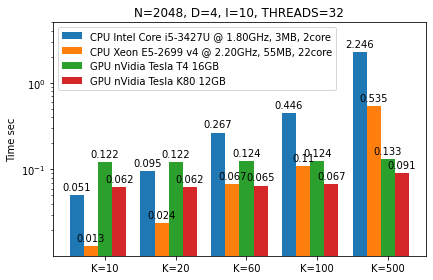

Dal grafico sopra é possibile notare come con dati di piccola dimensione (e K centroidi fissati a 10, 20 o 60) il processore server sia migliore in termini di tempo totale di esecuzione; tuttavia é anche possibile notare che la crescita di tempi del processore é esponenziale, mentre quella della GPU rimane quasi invariata. 

**N.B. La scala usata é logaritmica**

#### reg-gkmeans vs kmeans (70K dataset)
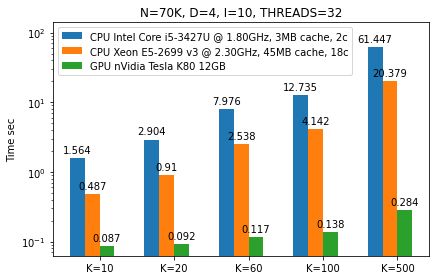

Il grafico successivo (reg-gkmeans vs kmeans 70K dataset) mostra come il tempo di esecuzione della GPU sia anch'esso esponenziale rispetto al crescere del numero di centroidi, ma la crescita é meno pronunciata rispetto alle CPU.

**N.B. La scala usata é logaritmica**

##mtx-gkmeans

Il software mtx-gkmeans consiste in un'implementazione (tramite il linguaggio CUDA C) per GPU nVidia che sfrutta le matrici, ed in particolare l'ottimizzazione dei caloli matriciali attraverso la shared memory, diversamente dall'approccio classico che legge i dati dalla memoria globale.

É stato scelto di ottimizzare il codice C come segue: la funzione `calculate_distances()` (funzione piú onerosa in termini di tempo occupato) riceve in input il dataset dei punti iniziali e dei centroidi del round attuale, e ne calcola le distanze. I dati vengono forniti sottoforma di vettori linearizzati, ma per chiarezza nella descrizione saranno utilizzate delle matrici 2/3D.

L'ottimizzazione applicata in questo algoritmo consiste nel vedere la matrice dei centroidi disposta come $D \cdot K$ e non come $K \cdot D$ come accadeva nell'algoritmo classico per CPU.

||k0|k1|k2|k3|k4|k5|k6|k7|
|-|-|-|-|-|-|-|-|-|
|d0|3|5|3|7|3|9|1|2|
|d1|5|7|9|4|4|2|7|8|
|d2|2|4|7|9|4|7|2|7|
>_mtx-gkmeans gcentroids_

||d0|d1|d2|
|-|-|-|-|
|k0|3|5|3|
|k1|5|7|9|
|k2|2|4|7|
|k3|4|6|9|
|k4|9|2|6|
|k5|7|3|5|
|k6|6|1|9|
|78|2|5|1|
> _kmeans centroids (standard)_

Questa visione aggiunge il vantaggio di poter usare la shared memory come é  possibile fare nella moltiplicazione tra matrici, questo perché entrambe le matrici _gdataset_ e _gcentroids_ hanno il lato $D$ delle dimensioni in comune. Si procede quindi con la seguente attivazione del kernel:

```cpp
dim3 block(TILE, TILE);
dim3 grid( (int)ceil((double)K / TILE), (int)ceil((double)N / TILE));
uint smem_size = (TILE * TILE) * sizeof(float) * 2;

for(int z = 0; z < ITER; z++){
  calculate_distances<<<grid, block, smem_size>>>(gdataset, gcentroids, gdistances);
  ...
```

Si é deciso di lasciar inserire all'utente la variabile `int TILE`, in modo che fosse piú facile eseguire dei test automatici a posteriori, per validare l'algoritmo con diversi parametri.
La dimensione della shared memory é stata scelta in base alla dimensione delle sottomatrici da gestire `m[TILE][TILE]`, moltiplicata per il numero delle sottomatrici `2` e per la dimensione dei dati `sizeof(float)`. Successivamente, per il numero di volte indicato dalle iterazioni, si attiva il kernel `calculate_distances<<<grid, block, smem_size>>>(gdataset, gcentroids, gdistances)` che riempie la matrice delle distanze dopo aver preso in input le matrici lineatizzate di dataset e centroidi.

Il kernel non differisce molto da una moltiplicazione matriciale. In particolare, dopo aver caricato le sottomatrici nella shared memory, si provvede a calcolare la distanza euclidea per ogni riga e colonna delle sottomatrici:

```c
__constant__ int gN;
__constant__ int gK;
__constant__ int gD;
__constant__ int gTILE;

extern __shared__ char smem[];

__global__ void calculate_distances(float *dataset, float *centroids, float *distances){

	uint y = blockIdx.y * gTILE + threadIdx.y;
  uint x = blockIdx.x * gTILE + threadIdx.x;

  float result = .0;
  float *a = (float *) smem;
  float *b = (float *) &smem[gTILE * gTILE * sizeof(float)];

  for(int z = 0; z < ceil((double)gD / gTILE); z++){

    a[threadIdx.y * gTILE + threadIdx.x] = dataset[y * gD + (z * gTILE + threadIdx.x)];
    b[threadIdx.y * gTILE + threadIdx.x] = centroids[(z * gTILE + threadIdx.y) * gK + x];
    // dataset[y][z * TILE + threadIdx.x]
    // centroids[z * TILE + threadIdx.y][x]

    __syncthreads();

    for(int t = 0; t < gTILE; t++)
      result += pow(a[threadIdx.y * gTILE + t] - b[t * gTILE + threadIdx.x], 2); 
      //result += a[threadIdx.y][t], b[t][threadIdx.x]
    
    __syncthreads();
  }

  if(y < gN && x < gK)
    distances[y * gK + x] = sqrt(result);
}
```

Successivamente al calcolo delle distanze, per completare l'assegnamento dei punti nei cluster il device esegue `closest_centroid<<<BLOCKS, THREADS>>>(gdistances, gmap_p2c)`, una funzione di assegnamento dei punti nei centroidi. 
Il kernel utilizza la matrice linearizzata delle distanze per individuare per ogni punto il centroide ad esso piú vicino: questo avviene attivando un numero di thread totali necessari a coprire il numero di punti all'interno del dataset. I thread sono divisi in blocchi lineari da `THREADS` thread l'uno e la griglia é composta da `BLOCKS` blocchi.

```c
for(int z = 0; z < ITER; z++){

  ...      

  calculate_distances<<<grid, block, smem_size>>>(gdataset, gcentroids, gdistances);
  closest_centroid<<<BLOCKS, THREADS>>>(gdistances, gmap_p2c); 

  cudaMemcpy(map_p2c, gmap_p2c, sizeof(int) * N, cudaMemcpyDeviceToHost);

  // CPU ricalcolo dei nuovi centroidi

  cudaMemcpy(gcentroids, centroids, sizeof(float) * D * K, cudaMemcpyHostToDevice);
  }
```

Il kernel sotto riportato scannerizza tutte le distanze calcolate per ogni punto e trova l'indice di distanza minima, che viene inserito nel vettore che mappa ogni punto con il centroide di appartenenza.

```c
__global__ void closest_centroid(float *gdistances, int *gmap_p2c){

  int idx = blockIdx.x * blockDim.x + threadIdx.x;

  if(idx < gN){
    float dmin = gdistances[idx * gK];
    int imin = 0;
    for(int k = 0; k < gK; k++){
      if(gdistances[idx * gK + k] < dmin){
        dmin = gdistances[idx * gK + k];
        imin = k;
      }
    }

    gmap_p2c[idx] = imin;
  }

}
```



#### mtx-gkmeans3

In aggiunta a quanto indicato nell'articolo di riferimento, si é voluto testare un ulteriore grado di parallelismo nella ricomputazione dei centroidi date le varie distanze.
In particolare la strategia utilizzata é quella di applicare una parallel reduction tridimensionale, in modo che al termine di essa nella prima riga della matrice si possa trovare la somma di ogni centroide, da dividere successivamente per il numero di punti contenutivi.

```c
for(int z = 0; z < ITER; z++){

  ...
      
  calculate_distances<<<grid, block, smem_size>>>(gdataset, gcentroids, gdistances);
  closest_centroid<<<BLOCKS, THREADS>>>(gdistances, gsize, gpartial_sum, gdataset);

  int i = 0;
  int h = N;
  do{
    h -= h / 2;
    dim3 gridPoints(K,h);
    centroids_sum<<<gridPoints, D>>>(gpartial_sum, pow(2,i));
    centroids_weight<<<h, K>>>(gsize, pow(2,i));
    i++;
  }while(h > 1);

  new_centroids<<<K,D>>>(gcentroids, gpartial_sum, gsize);
}
cudaMemcpy(centroids, gcentroids, sizeof(float) * D * K, cudaMemcpyDeviceToHost);
```

Nell'immagine sottostante é possibile vedere lo schema utilizzato per l'esecuzione del kernel `centroids_sum` tramite parallel reduction (il kernel `centroids_weight` é svolto in maniera simile). In particolare si puó notare come la parallel recuction sia gestita a livello di grid mentre la dimensionalitá sia gestita a livello di blocco, con tanti thread quante sono le dimensioni.

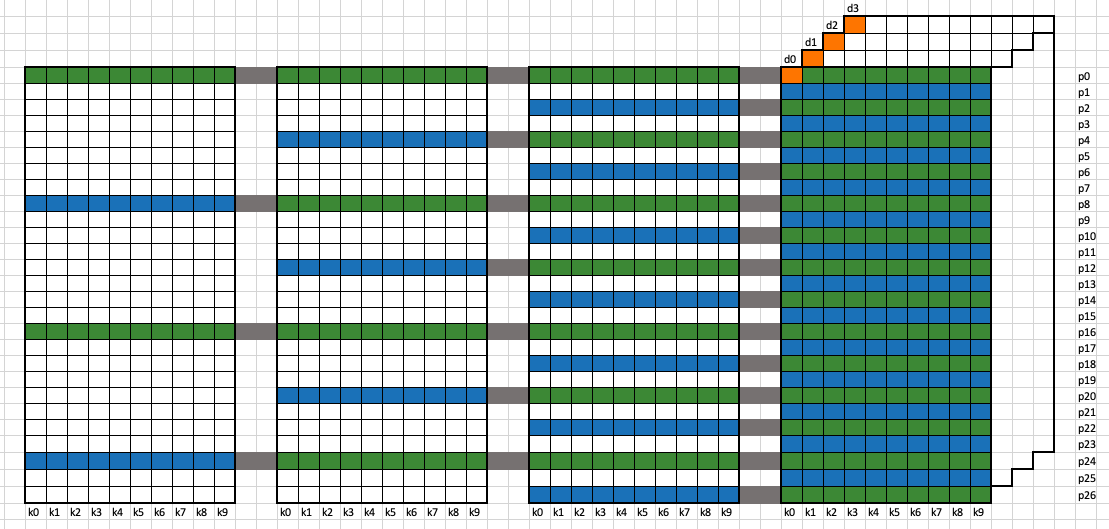


#### mtx-gkmeans benchmark
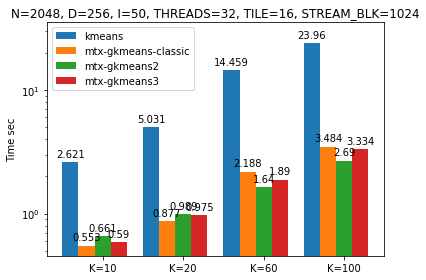

Sono stati confrontati tutti gli algoritmi ottimizzati, sia con la versione classica su CPU che con la versione semplice per GPU. Come é possibile notare gli algoritmi per GPU hanno tempi di esecuzione simili, decisamente migliori rispetto alla versione CPU.
Confrontando tra loro le esecuzioni gkmeans si puó osservare che la versione 3 (con l'ottimizzazione delle somme in parallel redecution) ha lo stesso tempo di esecuzione della versione classica per GPU; l'ottimizzazione migliore rimane quella indicata dal paper.

Sebbene la versione mtx-gkmeans3 sembrerebbe quella che fa uso piú massiccio della GPU, e di conseguenza quella che dovrebbe avere il maggiore vantaggio intermini di velocitá, non é cosí questo perché probabilmente la parallel reduction é efficiente nei primi passaggi e non efficiente negli ultimi; l'uso della CPU negli ultimi passaggi potrebbe far diminuire il tempo di esecuzione. In particolare questo é vero per il kernel `centroids_weight` e meno vero per il kernel `centroids_sum` che invece attiva comunque un alto numero di thread, poiché la matrice ha una dimensione (profonditá) in piú.

Un'ulteriore ottimizzazione pensata é stata quella di introdurre delle versioni con stream, per capire quanto l'affermazione fatta in precedenza possa essere verificata.

```plain
==826== Profiling application: ./mtx-gkmeans3 /content/drive/My Drive/gpu/assets/g2-32-20.txt 2048 20 32 50 32 16
==826== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   88.26%  90.714ms        50  1.8143ms  1.8136ms  1.8215ms  calculate_distances(float*, float*, float*)
                    9.23%  9.4844ms       550  17.244us  1.2150us  87.806us  centroids_sum(float*, int)
                    1.48%  1.5241ms        50  30.481us  29.568us  31.487us  closest_centroid(float*, int*, float*, float*)
                    0.84%  863.06us       550  1.5690us  1.0880us  3.5200us  centroids_weight(int*, int)
                    0.10%  98.236us       100     982ns     928ns  1.2160us  [CUDA memset]
                    0.06%  64.031us        50  1.2800us  1.2480us  1.5680us  new_centroids(float*, float*, int*)
                    0.03%  30.015us         6  5.0020us  1.0240us  24.191us  [CUDA memcpy HtoD]
                    0.00%  1.5360us         1  1.5360us  1.5360us  1.5360us  [CUDA memcpy DtoH]
```


## mtx-gkmeans-stream

Come anticipato nella sezione precedente, si é deciso di implementare una versione con stream differenti, in modo che le due funzioni di calcolo delle somme parziali e di calcolo dei pesi dei centroidi avvengano in parallelo (fin'ora erano avvenute in modo sequenziale). Questo é possibile grazie all'uso degli stream in CUDA. 

```c
int i = 0;
int h = N;
do{
  h -= h / 2;
  dim3 gridPoints(K,h); //x,y
  centroids_sum<<<gridPoints, D, 0, stream[0]>>>(gpartial_sum, pow(2,i));
  centroids_weight<<<h, K, 0, stream[1]>>>(gsize, pow(2,i));
  i++;
}while(h > 1);
```

Come é possibile osservare i due kernel (ed anche alcune operazioni di copia precedenti) sono svolti su stream differenti, questa configurazione permette di considerare solo il tempo del kernel piú lungo, se i kernel vengono eseguiti esattamente in tempi sovrapposti.

Osservando il grafico successivo si puó vedere come questa ottimizzazione é apprezzabile quando il numero di cluster da individuare cresce.

### mtx-gkmeans-stream benchmark

Potrebbe essere utile in questo caso lo studio del grafico temporale prodotto da nvvp, di seguito sono riportati degli screenshoot estrapolati dal visual profile di nVidia. Come giá evidenziato si nota un miglioramento generale dell'algoritmo, ma si evidenza un fatto particolarmente strano: i due kernel lanciati su stream differenti non vengono eseguiti in modo completamente parallelo come ci si aspetterebbe. Questo potrebbe essere dovuto al fatto che `centroids_sum` satura le risorse della GPU, impedendo il parallelismo e di conseguenza costringendo lo scheduler a rendere parzialmente sequenziale l'esecuzione. Solo nella parte finale, quando si presume che le risorse siano pian piano rilasciate, anche il kernel sullo stream differente parte.

#####mtx-gkmeans-stream k80
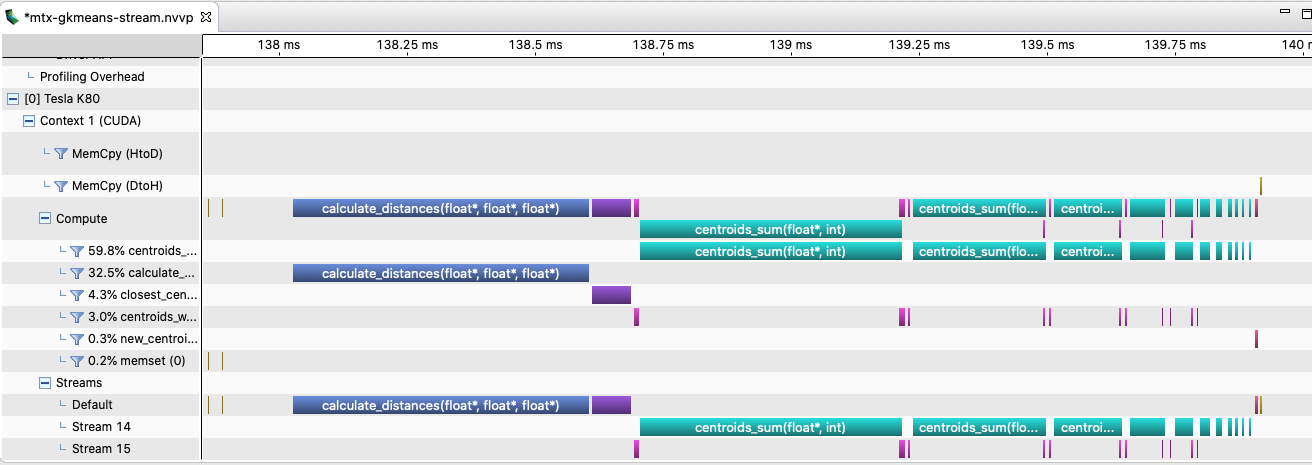

Ulteriore miglioria applicata per ridurre il tempo di esecuzione é stata spostare il carico di `centroids_weight` dalla GPU alla CPU, ed eseguire la funzione in parallelo dopo aver lanciato i kernel relativi a `centroids_sum`. É possibile vedere nel grafico di nvvp la presenza di un blocco di colore oro, che indica lo spostamento dalla memoria device alla memoria host di `gsize`, per poter eseguire `centroids_weight` su CPU.

#####mtx-gkmeans-stream2 k80
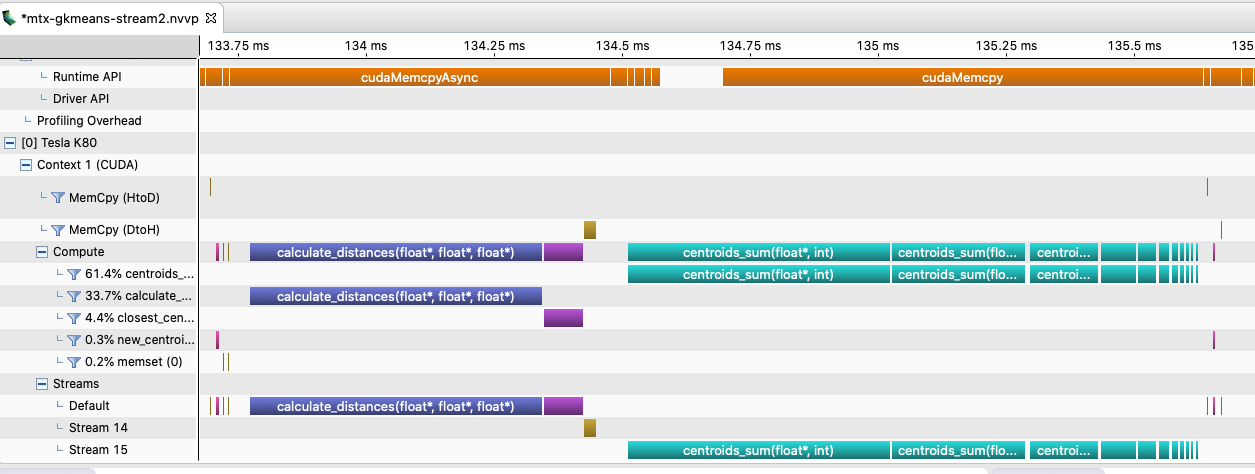

Questo algoritmo, prendendo come riferimento mtx-gkmeans-stream prova a diminuire la complessitá del kernel piú pesante calculate_distances(), dividendo il dataset in due parti in modo che sia eseguibile su due stream differenti.

Questa versione non vuole essere definitiva, ma solo dimostrativa del fatto che questa ottimizzazione é l'unica che é possibile applicare con un grosso vantaggio dopo il giá ottimo improvement raggiunto tramite l'introduzione della shared memory.

#####mtx-gkmeans-stream3 k80
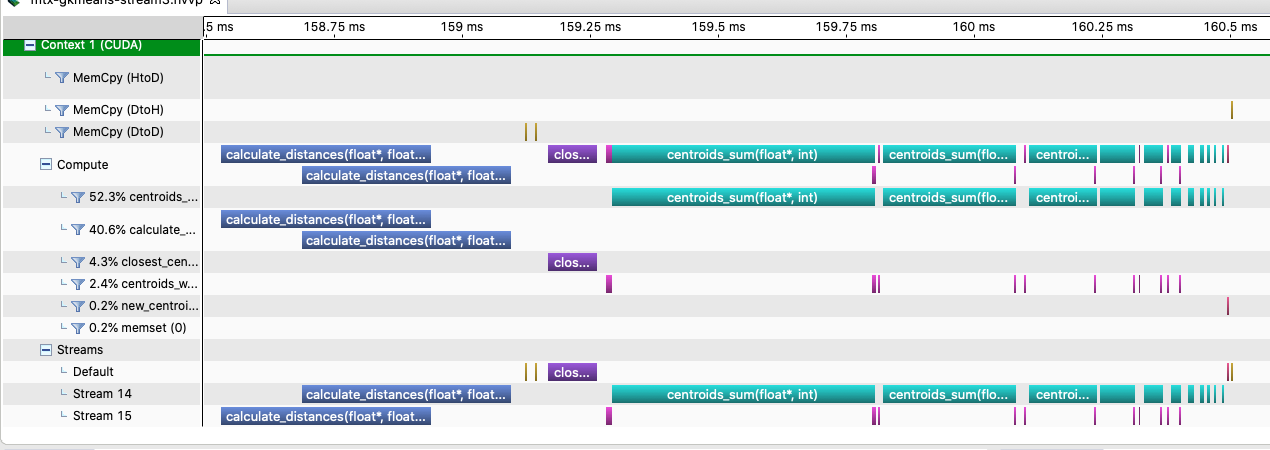

Dal grafico successivo si nota che nonostante le varie migliorie applicate, la piú performante nei test eseguiti risulta quella indicata dal articolo; le restanti 3 (stream) sono simili nel tempo totale di esecuzione.

####mtx-gkmeans-stream
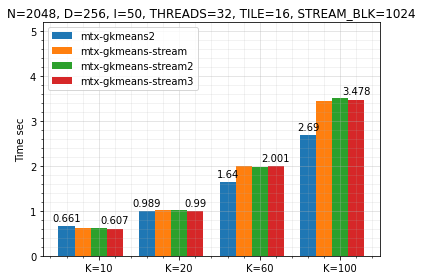

#### Confronto sul tempo di esecuzione di  `calculate_distances` con diverse schede nVidia su Colab
| Anno | Arch | Scheda | Cuda core| mtx-gkmeans2/3 |  mtx-gkmeans-stream /2 |  mtx-gkmeans-stream3 |
| --- | --- | --- | --- | --- | --- | --- |
| 2016 | Pascal | Tesla P100 | 3584 | 0,12ms | 0,28ms | |
| 2018 | Turing | Tesla T4 | 2560 | 4,94ms | 5,05ms | 5,2ms |
| 2014 | Kepler | Tesla K80 | 4992 | 0,56ms | 0,60ms | 0,60ms |

## Conclusioni 
Sebbene gli algoritmi non siano tra loro confrontabili, in quanto non é possibile eseguire `reg-gkmeans` con dimensionalitá alte senza ottenere un register spilling, si é voluto comunque proporre due tabelle comparative per dimensionalitá fino a 32D. Nelle tabelle presentate, come ci si aspettava, l'algoritmo che fa uso di registri é piú efficiente, tuttavia per dimensioni piú alte la sua velocitá é pari a quella di `mtx-gkmeans-classic`.

> N=2048 K=20 ITER=10 THREADS=32

| Algo | D=4 | D=8 | D=16 | D=32 |
| --- | --- | --- | --- | --- |
| reg-gkmeans | 0.063 | 0.066 | 0.070 | 0.077 |
| mtx-gkmeans | 0.066 | 0.069 | 0.072 | 0.086 |
|  | +5% | +5% | +3% | +11% |


> N=2048 K=100 ITER=10 THREADS=32

| Algo | D=4 | D=8 | D=16 | D=32 |
| --- | --- | --- | --- | --- |
| reg-gkmeans | 0.069 | 0.076 | 0.087 | 0.111 |
| mtx-gkmeans | 0.074 | 0.083 | 0.107 | 0.155 |
|  | +7% | +9% | +18% | +28% |


L'algoritmo piú veloce rimane quello indicato dall'articolo di riferimento, ovvero quello che fa uso della GPU solo per quanto riguarda il calcolo delle distanze e l'associazione di ciascun punto al centroide piú vicino (operazioni piú onerose).

La difficoltá di trovare un miglioramento ad un algoritmo, in modo che questo sia applicabile su GPU, consiste nel ricondursi a dei casi base risolvibili in maniera parallela (es. parallel reduction); purtroppo questo concetto non é sempre applicabile.

## Enviorment setup

### Setting CUDA toolchain

**Check CUDA version**

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


**Execute the given command to install a small extension to run nvcc from Notebook cells**

In [ ]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-u0z7ww6y
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-u0z7ww6y
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-cp36-none-any.whl size=4307 sha256=00a4cfb0766065dc0c2c2971d68517b7d5f460e92d44e0a894f532b7eb510d79
  Stored in directory: /tmp/pip-ephem-wheel-cache-vopkqgyf/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin


**Load the extension just installed**

In [ ]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


###Device information check

In [ ]:
%%cu
#include <stdio.h>

// Print device properties
void printDevProp(cudaDeviceProp devProp)
{
    printf("Major revision number:         %d\n",  devProp.major);
    printf("Minor revision number:         %d\n",  devProp.minor);
    printf("Name:                          %s\n",  devProp.name);
    printf("Total global memory:           %lu\n",  devProp.totalGlobalMem);
    printf("Total shared memory per block: %lu\n",  devProp.sharedMemPerBlock);
    printf("Total registers per block:     %d\n",  devProp.regsPerBlock);
    printf("Warp size:                     %d\n",  devProp.warpSize);
    printf("Maximum memory pitch:          %lu\n",  devProp.memPitch);
    printf("Maximum threads per block:     %d\n",  devProp.maxThreadsPerBlock);
    for (int i = 0; i < 3; ++i)
        printf("Maximum dimension %d of block:  %d\n", i, devProp.maxThreadsDim[i]);
    for (int i = 0; i < 3; ++i)
        printf("Maximum dimension %d of grid:   %d\n", i, devProp.maxGridSize[i]);
    printf("Clock rate:                    %d\n",  devProp.clockRate);
    printf("Total constant memory:         %lu\n",  devProp.totalConstMem);
    printf("Texture alignment:             %lu\n",  devProp.textureAlignment);
    printf("Concurrent copy and execution: %s\n",  (devProp.deviceOverlap ? "Yes" : "No"));
    printf("Number of multiprocessors:     %d\n",  devProp.multiProcessorCount);
    printf("Kernel execution timeout:      %s\n",  (devProp.kernelExecTimeoutEnabled ?"Yes" : "No"));
    return;
}
 
int main()
{
    int devCount;
    cudaGetDeviceCount(&devCount);
    printf("CUDA Device Query...\n");
    printf("There are %d CUDA devices.\n", devCount);
 
    for (int i = 0; i < devCount; ++i)
    {
        // Get device properties
        printf("\nCUDA Device #%d\n", i);
        cudaDeviceProp devProp;
        cudaGetDeviceProperties(&devProp, i);
        printDevProp(devProp);
    }
    return 0;
}

CUDA Device Query...
There are 1 CUDA devices.

CUDA Device #0
Major revision number:         7
Minor revision number:         5
Name:                          Tesla T4
Total global memory:           15812263936
Total shared memory per block: 49152
Total registers per block:     65536
Warp size:                     32
Maximum memory pitch:          2147483647
Maximum threads per block:     1024
Maximum dimension 0 of block:  1024
Maximum dimension 1 of block:  1024
Maximum dimension 2 of block:  64
Maximum dimension 0 of grid:   2147483647
Maximum dimension 1 of grid:   65535
Maximum dimension 2 of grid:   65535
Clock rate:                    1590000
Total constant memory:         65536
Texture alignment:             512
Concurrent copy and execution: Yes
Number of multiprocessors:     40
Kernel execution timeout:      No



###Mounting Google Drive filesystem

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Implementation

###kmeans CPU

_Versione CPU dell'algoritmo kmeans gestito tramite matrici dimensionali._

In [ ]:
%%cuda -n kmeans.cu
#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <math.h>
#include <unistd.h>
#include <inttypes.h>
#include <time.h>

int N;
int K;
int D;
int ITERATIONS;

void load_file(float *dataset, char *filename){
  FILE *file  = fopen(filename, "r");
  
  if (file == NULL) {
    printf("Error! Could not open file\n");
    return;
  }

  int i = 0;
  uint32_t num;
  while(fscanf(file, "%ud", &num) > 0) {
    dataset[i] = num;
    i++;
  }
  
  fclose(file);
}

float d(float *p0, float *p1){

  float dist = .0;
  for(int d = 0; d < D; d++)
    dist += pow(p0[d] - p1[d], 2);

  return sqrt(dist);
}

void kmeans(float* centroids, float* dataset){

  int map_p2c[N];
  int size[K];
  
  // Initial cluster assignation technique
  memcpy(centroids, dataset, sizeof(float) * K * D);

  for(int z = 0; z < ITERATIONS; z++){
      
    // bind points to cluster
    for(int n = 0; n < N; n++){
      int idxmin = 0;
      float dmin = d(&dataset[n * D], &centroids[idxmin * D]);
      for(int k = 0; k < K; k++){
        float dist = d(&dataset[n * D], &centroids[k * D]);
        if(dist < dmin){
          dmin = dist;
          idxmin = k;
        }
      }
      map_p2c[n] = idxmin;
    }

    // clear old centroids
    memset(centroids, 0, sizeof(float) * K * D);
    memset(size, 0, sizeof(int) * K);
    
    // set new centroids
    for(int i = 0; i < N; i++){
      int k = map_p2c[i];
      for(int d = 0; d < D; d++)
        centroids[k * D + d] += dataset[i * D + d];
      size[k]++;
    }

    for(int k = 0; k < K; k++)
      for(int d = 0; d < D; d++)
        centroids[k * D + d] /= size[k];
  }

}

int main(int argc, char **argv){

  sscanf(argv[2],"%d",&N);
  sscanf(argv[3],"%d",&K);
  sscanf(argv[4],"%d",&D);
  sscanf(argv[5],"%d",&ITERATIONS);

  float dataset[N * D];     //   dataset[N][D]
  float centroids[K * D];   // centroids[K][D]

  printf("kmeans (N=%d, K=%d, D=%d, ITER=%d)\n", N, K, D, ITERATIONS);
  load_file(dataset, argv[1]);
  
  clock_t begin = clock();
  kmeans(centroids, dataset);
  clock_t end = clock();
  
  for(int k = 0; k < K; k++){
    printf("k=%d (", k);
    for(int d = 0; d < D; d++)
      printf("%.2f; ", centroids[k * D + d]);
    printf(")\n");
  }

  double time_spent = (double)(end - begin) / CLOCKS_PER_SEC;
  printf("Time: %f", time_spent);

  return 0;
}

'File written in /content/src/kmeans.cu'

In [ ]:
!mv src/kmeans.cu src/kmeans.c
!gcc src/kmeans.c -o kmeans -lm -Wall

In [ ]:
!./kmeans "/content/drive/My Drive/gpu/assets/g2-32-20.txt" 2048 20 32 10 32

kmeans (N=2048, K=20, D=32, ITER=10)
k=0 (507.39; 486.37; 487.56; 486.10; 507.56; 497.44; 497.02; 495.12; 495.95; 488.29; 495.66; 510.76; 498.22; 504.29; 479.95; 495.93; 492.07; 502.90; 515.80; 509.90; 504.61; 503.56; 503.71; 504.44; 493.56; 510.41; 489.49; 480.76; 500.76; 502.44; 501.85; 494.20; )
k=1 (489.93; 503.77; 503.16; 501.62; 496.64; 501.92; 510.43; 507.87; 516.15; 508.18; 502.02; 503.28; 497.95; 493.51; 502.10; 508.23; 506.74; 495.48; 500.05; 503.36; 515.67; 518.41; 496.00; 497.46; 492.66; 512.77; 491.57; 492.31; 500.07; 497.15; 485.82; 493.61; )
k=2 (493.86; 509.74; 509.93; 507.14; 499.19; 496.81; 495.58; 492.30; 512.02; 494.37; 505.95; 489.63; 496.35; 487.07; 514.44; 491.91; 498.84; 484.49; 501.16; 479.91; 486.79; 499.23; 503.67; 508.51; 488.91; 500.51; 488.77; 499.00; 507.74; 505.21; 495.02; 507.16; )
k=3 (488.50; 502.18; 494.00; 504.25; 503.43; 497.85; 509.76; 512.24; 505.08; 510.50; 492.50; 505.44; 494.78; 490.17; 498.06; 508.72; 494.97; 497.92; 488.31; 502.85; 487.47; 4

In [ ]:
!./kmeans "/content/drive/My Drive/gpu/assets/g2-512-10.txt" 2048 10 512 10 32

kmeans (N=2048, K=10, D=512, ITER=10)
k=0 (599.54; 599.55; 599.29; 599.16; 599.95; 599.37; 599.44; 599.53; 599.49; 599.52; 599.47; 599.05; 599.62; 599.04; 599.69; 599.43; 599.44; 599.55; 599.55; 599.85; 599.46; 599.51; 599.61; 599.31; 599.50; 599.47; 599.60; 599.65; 599.78; 598.89; 599.14; 598.94; 599.66; 599.62; 599.65; 599.86; 599.43; 599.63; 599.57; 599.58; 599.51; 599.59; 599.34; 598.84; 599.70; 598.78; 599.26; 599.71; 599.53; 599.56; 599.37; 599.57; 599.18; 599.54; 599.08; 599.65; 598.95; 599.65; 599.16; 599.59; 599.87; 599.62; 599.72; 599.45; 600.04; 599.53; 599.82; 599.79; 599.18; 599.53; 599.54; 599.33; 599.36; 599.86; 599.91; 599.55; 599.29; 599.37; 599.20; 599.68; 599.46; 599.35; 599.78; 599.52; 599.25; 599.42; 599.54; 599.87; 599.34; 599.53; 600.07; 599.71; 599.70; 599.76; 599.05; 599.11; 599.66; 599.77; 599.47; 599.66; 599.53; 599.71; 599.85; 600.09; 599.00; 599.87; 599.22; 600.11; 599.87; 599.86; 599.49; 599.87; 599.73; 599.11; 600.09; 599.55; 599.59; 599.51; 599.51; 599.5

In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2200.000
BogoMIPS:            4400.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

### Register gkmeans

#### reg-gkmeans-v1

_Versione ottimizzata con utilizzo di registri on-board e gestione di struttura._


In [ ]:
%%cuda -n reg-gkmeans-v1.cu
#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <math.h>
#include <unistd.h>
#include <inttypes.h>

int N;
int K;
int D;
int ITER;

int THREADS;
int BLOCKS;

#define CHECK(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess) 
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}

typedef struct point{
  float x;
  float y;
  float z;
  float t;
} point_t;

void load_file(point_t *dataset, char *filename){
  FILE *file  = fopen(filename, "r");
  char line[1024];
  float a, b, c, d;
           
  if (file == NULL) {   
    printf("Error! Could not open file\n"); 
    return;
  } 

  int i = 0;
  while (fgets(line, sizeof(line), file)) {
    if(sscanf(line, "%f %f %f %f", &a, &b, &c, &d) > 0){
      dataset[i].x = a;
      dataset[i].y = b;
      dataset[i].z = c;
      dataset[i].t = d;
      i++;
    }
  }
  
  fclose(file);
}

__device__ float d(float p0_x, float p0_y, float p0_z, float p0_t,
                   float p1_x, float p1_y, float p1_z, float p1_t){
                           
  return sqrtf(powf(p1_x - p0_x, 2) +
               powf(p1_y - p0_y, 2) + 
               powf(p1_z - p0_z, 2) +
               powf(p1_t - p0_t, 2));
}

__global__ void closest_centroid(point_t *gdataset, point_t *gcentroids, int *gmap_p2c, int gK){
    
  int idx = blockIdx.x * blockDim.x + threadIdx.x;

  float p_x = gdataset[idx].x;
  float p_y = gdataset[idx].y;
  float p_z = gdataset[idx].z;
  float p_t = gdataset[idx].t;

  int idxmin = 0;
  float dmin = d(p_x, p_y, p_z, p_t,
                 gcentroids[idxmin].x, gcentroids[idxmin].y, gcentroids[idxmin].z, gcentroids[idxmin].t);
  
  for(int k = 0; k < gK; k++){
    float dist = d(p_x, p_y, p_z, p_t,
                 gcentroids[k].x, gcentroids[k].y, gcentroids[k].z, gcentroids[k].t);
    if(dist < dmin){
      dmin = dist;
      idxmin = k; 
    }
  }

  gmap_p2c[idx] = idxmin;
}

void kmeans(point_t* centroids, point_t* dataset){

  int map_p2c[N];
  int size[K];

  // Initial cluster assignation technique
  memcpy(centroids, dataset, sizeof(point_t) * K);

  point_t* gdataset;
  cudaMalloc((void**)&gdataset, sizeof(point_t) * N);
  cudaMemcpy(gdataset, dataset, sizeof(point_t) * N, cudaMemcpyHostToDevice);

  point_t* gcentroids;
  cudaMalloc((void**)&gcentroids, sizeof(point_t) * K);
  cudaMemcpy(gcentroids, centroids, sizeof(point_t) * K, cudaMemcpyHostToDevice);

  int* gmap_p2c;
  cudaMalloc((void**)&gmap_p2c, sizeof(int) * N);

  for(int i = 0; i < ITER; i++){
      
    closest_centroid <<<BLOCKS, THREADS>>>(gdataset, gcentroids, gmap_p2c, K); 
    cudaMemcpy(map_p2c, gmap_p2c, sizeof(int) * N, cudaMemcpyDeviceToHost);

    // clear old centroids
    memset(size, 0, sizeof(int) * K);
    for(int k = 0; k < K; k++){
      centroids[k].x = 0;
      centroids[k].y = 0;
      centroids[k].z = 0;
      centroids[k].t = 0;
    }
    
    // set new centroids
    for(int n = 0; n < N; n++){
      int idx = map_p2c[n];
      centroids[idx].x += dataset[n].x;
      centroids[idx].y += dataset[n].y;
      centroids[idx].z += dataset[n].z;
      centroids[idx].t += dataset[n].t;
      size[idx]++;
    }

    for(int k = 0; k < K; k++){
      int total = size[k];
      centroids[k].x = centroids[k].x / total;
      centroids[k].y = centroids[k].y / total;
      centroids[k].z = centroids[k].z / total;
      centroids[k].t = centroids[k].t / total;
    }

    cudaMemcpy(gcentroids, centroids, sizeof(point_t) * K, cudaMemcpyHostToDevice);
  }

  cudaFree(gdataset);
  cudaFree(gcentroids);
  cudaFree(gmap_p2c);
  cudaDeviceSynchronize();
}

int main(int argc, char **argv){

  sscanf(argv[2],"%d",&N);
  sscanf(argv[3],"%d",&K);
  sscanf(argv[4],"%d",&D);
  sscanf(argv[5],"%d",&ITER);
  sscanf(argv[6],"%d",&THREADS);
  BLOCKS = (int)ceil((double)N / THREADS);

  point_t points[N];
  point_t centroids[K];

  printf("kmeans (N=%d, K=%d, ITER=%d, THREADS=%d, BLOCKS=%d)\n", N, K, ITER, THREADS, BLOCKS);
  load_file(points, argv[1]);
   
  clock_t begin = clock();
  kmeans(centroids, points);
  clock_t end = clock();

  for(int k = 0; k < K; k++)
    printf("k=%d (%.2f; %.2f; %.2f; %.2f)\n", k, centroids[k].x, centroids[k].y, centroids[k].z, centroids[k].t);

  double time_spent = (double)(end - begin) / CLOCKS_PER_SEC;
  printf("Time: %f", time_spent);

  return 0;
}

'File written in /content/src/reg-gkmeans-v1.cu'

In [ ]:
!nvcc src/reg-gkmeans-v1.cu -o reg-gkmeans-v1 

In [ ]:
!./reg-gkmeans-v1 "/content/drive/My Drive/gpu/assets/g2-4-20.txt" 2048 2 4 1000 32

kmeans (N=2048, K=2, ITER=1000, THREADS=32, BLOCKS=64)
k=0 (500.19; 499.39; 499.50; 499.43)
k=1 (599.97; 600.30; 600.83; 599.35)
Time: 0.234363

In [ ]:
!time ./reg-gkmeans-v1 "/content/drive/My Drive/gpu/assets/g2-4-20.txt" 2048 2 4 1000 32

kmeans (N=2048, K=2, ITER=1000, THREADS=32, BLOCKS=64)
k=0 (500.19; 499.39; 499.50; 499.43)
k=1 (599.97; 600.30; 600.83; 599.35)
Time: 0.161482
real	0m0.213s
user	0m0.061s
sys	0m0.136s


In [ ]:
!nvprof ./reg-gkmeans-v1 "/content/drive/My Drive/gpu/assets/g2-4-20.txt" 2048 2 4 1000 32

kmeans (N=2048, K=2, ITER=1000, THREADS=32, BLOCKS=64)
==424== NVPROF is profiling process 424, command: ./reg-gkmeans-v1 /content/drive/My Drive/gpu/assets/g2-4-20.txt 2048 2 4 1000 32
k=0 (500.19; 499.39; 499.50; 499.43)
k=1 (599.97; 600.30; 600.83; 599.35)
Time: 0.266176==424== Profiling application: ./reg-gkmeans-v1 /content/drive/My Drive/gpu/assets/g2-4-20.txt 2048 2 4 1000 32
==424== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   72.36%  8.9883ms      1000  8.9880us  8.9280us  10.753us  closest_centroid(point*, point*, int*, int)
                   16.61%  2.0635ms      1000  2.0630us  2.0480us  4.7360us  [CUDA memcpy DtoH]
                   11.02%  1.3691ms      1002  1.3660us  1.3120us  4.3520us  [CUDA memcpy HtoD]
      API calls:   81.33%  175.49ms         3  58.497ms  5.8630us  175.48ms  cudaMalloc
                   14.80%  31.935ms      2002  15.951us  4.9390us  583.02us  cudaMemcpy
                 

#### reg-gkmeans4

_Versione ottimizzata con registri GPU, dimensionalitá fissata 4._

In [ ]:
%%cuda -n reg-gkmeans4.cu
#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <math.h>
#include <unistd.h>
#include <inttypes.h>

int N;
int K;
int D;
int ITER;

int THREADS;
int BLOCKS;

__constant__ int gN;
__constant__ int gK;
__constant__ int gD;

#define CHECK(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess) 
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}

void load_file(float *dataset, char *filename){
  FILE *file  = fopen(filename, "r");
  
  if (file == NULL) {   
    printf("Error! Could not open file\n"); 
    return;
  } 

  int i = 0;
  uint32_t num;
  while(fscanf(file, "%ud", &num) > 0) {
    dataset[i] = num;
    i++;
  }
  
  fclose(file);
}

__global__ void closest_centroid(float *dataset, float *centroids, int *map_p2c){

  int idx = blockIdx.x * blockDim.x + threadIdx.x;

  float p0_d0 = dataset[idx * gD + 0]; // x
  float p0_d1 = dataset[idx * gD + 1]; // y
  float p0_d2 = dataset[idx * gD + 2]; // z
  float p0_d3 = dataset[idx * gD + 3]; // t
  
  if(idx < gN){
    int i = 0;
    float dmin = sqrt(
        powf(p0_d0 - centroids[0], 2) +
        powf(p0_d1 - centroids[1], 2) +
        powf(p0_d2 - centroids[2], 2) +
        powf(p0_d3 - centroids[3], 2) );
    
    for(int k = 0; k < gK; k++){
      float d = sqrt(
        powf(p0_d0 - centroids[k * gD + 0], 2) +
        powf(p0_d1 - centroids[k * gD + 1], 2) +
        powf(p0_d2 - centroids[k * gD + 2], 2) +
        powf(p0_d3 - centroids[k * gD + 3], 2) );
      if(d < dmin){
        dmin = d;
        i = k;
      }
    }

    map_p2c[idx] = i;
  }
}

void kmeans(float* centroids, float* dataset){

  int map_p2c[N];
  int size[K];

  cudaMemcpyToSymbol(gN, &N, sizeof(N));
  cudaMemcpyToSymbol(gK, &K, sizeof(K));
  cudaMemcpyToSymbol(gD, &D, sizeof(D));
  
  // Initial cluster assignation technique
  memcpy(centroids, dataset, sizeof(float) * K * D);

  float* gdataset;
  cudaMalloc((void**)&gdataset, sizeof(float) * N * D);
  cudaMemcpy(gdataset, dataset, sizeof(float) * N * D, cudaMemcpyHostToDevice);

  float* gcentroids;
  cudaMalloc((void**)&gcentroids, sizeof(float) * K * D);
  cudaMemcpy(gcentroids, centroids, sizeof(float) * K * D, cudaMemcpyHostToDevice);

  int* gmap_p2c;
  cudaMalloc((void**)&gmap_p2c, sizeof(int) * N);

  for(int i = 0; i < ITER; i++){
      
    closest_centroid<<<BLOCKS, THREADS>>>(gdataset, gcentroids, gmap_p2c); 
    cudaMemcpy(map_p2c, gmap_p2c, sizeof(int) * N, cudaMemcpyDeviceToHost);

    // clear old centroids
    memset(centroids, 0, sizeof(float) * K * D);
    memset(size, 0, sizeof(int) * K);
    
    // set new centroids
    for(int n = 0; n < N; n++){
      int k = map_p2c[n];
      for(int d = 0; d < D; d++)
        centroids[k * D + d] += dataset[n * D + d];
      size[k]++;
    }

    for(int k = 0; k < K; k++)
      for(int d = 0; d < D; d++)
        centroids[k * D + d] /= size[k];

    cudaMemcpy(gcentroids, centroids, sizeof(float) * K * D, cudaMemcpyHostToDevice);
  }

  cudaFree(gdataset);
  cudaFree(gcentroids);
  cudaFree(gmap_p2c);
  cudaDeviceSynchronize();
}

int main(int argc, char **argv){

  sscanf(argv[2],"%d",&N);
  sscanf(argv[3],"%d",&K);
  sscanf(argv[4],"%d",&D);
  sscanf(argv[5],"%d",&ITER);
  sscanf(argv[6],"%d",&THREADS);
  BLOCKS = (int)ceil((double)N / THREADS);

  float dataset[N * D];     //   dataset[N][D]
  float centroids[K * D];   // centroids[K][D]

  printf("kmeans (N=%d, K=%d, D=%d, ITER=%d, THREADS=%d, BLOCKS=%d)\n", N, K, D, ITER, THREADS, BLOCKS);
  load_file(dataset, argv[1]);
  
  clock_t begin = clock();
  kmeans(centroids, dataset);
  clock_t end = clock();
  
  for(int k = 0; k < K; k++){
    printf("k=%d (", k);
    for(int d = 0; d < D; d++)
      printf("%.2f; ", centroids[k * D + d]);
    printf(")\n");
  }

  double time_spent = (double)(end - begin) / CLOCKS_PER_SEC;
  printf("Time: %f", time_spent);

  return 0;
}

'File written in /content/src/reg-gkmeans4.cu'

In [ ]:
!nvcc --ptxas-options=-v src/reg-gkmeans4.cu -o reg-gkmeans4

ptxas info    : 0 bytes gmem, 12 bytes cmem[3]
ptxas info    : Compiling entry function '_Z16closest_centroidPfS_Pi' for 'sm_30'
ptxas info    : Function properties for _Z16closest_centroidPfS_Pi
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 26 registers, 344 bytes cmem[0], 40 bytes cmem[2]


In [ ]:
!./reg-gkmeans4 "/content/drive/My Drive/gpu/assets/g2-4-20.txt" 2048 2 4 1000 32

kmeans (N=2048, K=2, D=4, ITER=1000, THREADS=32, BLOCKS=64)
k=0 (500.19; 499.39; 499.50; 499.43; )
k=1 (599.97; 600.30; 600.83; 599.35; )
Time: 0.222713

In [ ]:
!time ./reg-gkmeans4 "/content/drive/My Drive/gpu/assets/g2-4-20.txt" 2048 2 4 1000 32

kmeans (N=2048, K=2, D=4, ITER=1000, THREADS=32, BLOCKS=64)
k=0 (500.19; 499.39; 499.50; 499.43; )
k=1 (599.97; 600.30; 600.83; 599.35; )
Time: 0.165913
real	0m0.214s
user	0m0.071s
sys	0m0.126s


In [ ]:
!nvprof ./reg-gkmeans4 "/content/drive/My Drive/gpu/assets/g2-4-20.txt" 2048 2 4 1000 32

kmeans (N=2048, K=2, D=4, ITER=1000, THREADS=32, BLOCKS=64)
==479== NVPROF is profiling process 479, command: ./reg-gkmeans4 /content/drive/My Drive/gpu/assets/g2-4-20.txt 2048 2 4 1000 32
k=0 (500.19; 499.39; 499.50; 499.43; )
k=1 (599.97; 600.30; 600.83; 599.35; )
Time: 0.267604==479== Profiling application: ./reg-gkmeans4 /content/drive/My Drive/gpu/assets/g2-4-20.txt 2048 2 4 1000 32
==479== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   74.23%  9.8621ms      1000  9.8620us  9.8240us  12.193us  closest_centroid(float*, float*, int*)
                   15.50%  2.0591ms      1000  2.0590us  2.0160us  2.4320us  [CUDA memcpy DtoH]
                   10.27%  1.3643ms      1005  1.3570us  1.3120us  4.1280us  [CUDA memcpy HtoD]
      API calls:   81.32%  166.67ms         3  55.556ms  6.9720us  166.65ms  cudaMemcpyToSymbol
                   14.74%  30.221ms      2002  15.095us  4.4900us  121.56us  cudaMemcpy
         

In [ ]:
!cuobjdump reg-gkmeans4 -ptx


Fatbin elf code:
arch = sm_30
code version = [1,7]
producer = <unknown>
host = linux
compile_size = 64bit

Fatbin elf code:
arch = sm_30
code version = [1,7]
producer = <unknown>
host = linux
compile_size = 64bit

Fatbin ptx code:
arch = sm_30
code version = [6,4]
producer = <unknown>
host = linux
compile_size = 64bit
compressed
ptxasOptions = -v  








.version 6.4
.target sm_30
.address_size 64


.const .align 4 .u32 gN;
.const .align 4 .u32 gK;
.const .align 4 .u32 gD;

.visible .entry _Z16closest_centroidPfS_Pi(
.param .u64 _Z16closest_centroidPfS_Pi_param_0,
.param .u64 _Z16closest_centroidPfS_Pi_param_1,
.param .u64 _Z16closest_centroidPfS_Pi_param_2
)
{
.reg .pred %p<141>;
.reg .f32 %f<878>;
.reg .b32 %r<102>;
.reg .b64 %rd<18>;


ld.param.u64 %rd4, [_Z16closest_centroidPfS_Pi_param_0];
ld.param.u64 %rd2, [_Z16closest_centroidPfS_Pi_param_1];
mov.u32 %r8, %ntid.x;
mov.u32 %r9, %ctaid.x;
mov.u32 %r10, %tid.x;
mad.lo.s32 %r11, %r8, %r9, %r10;
ld.const.u32 %r1, [gD];
mul.lo.s32

In [ ]:
!cuobjdump reg-gkmeans4 -xelf all

Extracting ELF file    1: reg-gkmeans4.1.sm_30.cubin
Extracting ELF file    2: reg-gkmeans4.2.sm_30.cubin


In [ ]:
!cuobjdump reg-gkmeans4.2.sm_30.cubin -res-usage


Resource usage:
 Common:
  GLOBAL:0 CONSTANT[3]:12
 Function _Z16closest_centroidPfS_Pi:
  REG:26 STACK:0 SHARED:0 LOCAL:0 CONSTANT[0]:344 CONSTANT[2]:40 TEXTURE:0 SURFACE:0 SAMPLER:0


In [ ]:
!cuobjdump reg-gkmeans4 -sass


Fatbin elf code:
arch = sm_30
code version = [1,7]
producer = <unknown>
host = linux
compile_size = 64bit

	code for sm_30

Fatbin elf code:
arch = sm_30
code version = [1,7]
producer = <unknown>
host = linux
compile_size = 64bit

	code for sm_30
		Function : _Z16closest_centroidPfS_Pi
	.headerflags    @"EF_CUDA_SM30 EF_CUDA_PTX_SM(EF_CUDA_SM30)"
                                                                                               /* 0x2280428282304307 */
        /*0008*/                   MOV R1, c[0x0][0x44];                                       /* 0x2800400110005de4 */
        /*0010*/                   S2R R0, SR_CTAID.X;                                         /* 0x2c00000094001c04 */
        /*0018*/                   MOV32I R4, 0x4;                                             /* 0x1800000010011de2 */
        /*0020*/                   S2R R3, SR_TID.X;                                           /* 0x2c0000008400dc04 */
        /*0028*/                   IMAD R0, R0, c[

```
code for sm_30
Function : _Z16closest_centroidPfS_Pi

  MOV R1, c[0x0][0x44];
* S2R R0, SR_CTAID.X; // r0 = blockIdx.x
  MOV32I R4, 0x4;
* S2R R3, SR_TID.X; // r3 = threadIdx.x
* IMAD R0, R0, c[0x0][0x28], R3;  // r0 = r0 * c[0x0][0x28] + r3 deduco che c[0x0][0x28] = blockDim.x
                                  // integer mult add
* SHL R3, R0, 0x2; // r3 = r0 << 0x2 (r0 * 0x100; idx * D)
  ISETP.GT.AND P0, PT, R0, 0x7ff, PT;

* ISCADD R2.CC, R3, c[0x0][0x140], 0x2; // r2 = r3 + c[0x0][0x140] << 2 (scalar add)
                                        // c[0x0][0x140] = *dataset (param); (dataset + (idx * D) ) << 2=sizeof(float)
  IMAD.HI.X R3, R3, R4, c[0x0][0x144];
                                        // integer shift add
@P0 EXIT;
  MOV R6, c[0x0][0x148];
  MOV R7, c[0x0][0xans14c];
* LD.E R5, [R2]; // float p0_d0 = dataset[idx * D + 0]; (r2 = dataset[idx * D], dataset + idx * D)
  MOV32I R9, 0xc3170000;

  LD.E R6, [R6];
  PBK 0x3d8;
  MOV32I R7, 0x3c4caf63;
  FADD R8, R5, -R6;
* LD.E R6, [R2+0xc]; // float p0_d3 = dataset[idx * D + 3];
  FSETP.GEU.AND P1, PT, |R8|, 1.175494350822287508e-38, PT;
  FADD R10, |R8|, -RZ;
@!P1
  FMUL R10, R10, 16777216;
  LOP32I.AND R0, R10, 0x7fffff;
  SHR.U32 R10, R10, 0x17;
  LOP32I.OR R0, R0, 0x3f800000;
  FSETP.GT.AND P0, PT, R0, c[0x2][0x4], PT;
@P0
  FMUL R0, R0, 0.5;
  FADD R12, R0, -1;

  FADD R0, R0, 1;
  MUFU.RCP R13, R0;
  FADD R0, R12, R12;
  FMUL R15, R13, R0;
  FMUL R0, R15, R15;
  FADD R11, R12, -R15;
  FFMA R4, R0, c[0x2][0x8], R7;

  FFMA R4, R0, R4, c[0x2][0xc];
  FADD R16, R11, R11;
  FMUL R0, R0, R4;
* LD.E R4, [R2+0x4]; // float p0_d1 = dataset[idx * D + 1];
  FMUL R14, R15, R0;
* LD.E R0, [R2+0x8]; // float p0_d2 = dataset[idx * D + 2];
  I2F.F32.U32 R11, R10;
```

https://stackoverflow.com/questions/30288669/branch-and-predicated-instructions

https://forums.developer.nvidia.com/t/the-meaning-of-cuda-disassemly/60924/8

https://docs.nvidia.com/cuda/cuda-binary-utilities/index.html#instruction-set-ref

https://repository.lib.ncsu.edu/bitstream/handle/1840.16/9585/etd.pdf?sequence=2&isAllowed=y

####reg-gkmeans8

_Versione ottimizzata con registri GPU, dimensionalitá fissata 8._

In [ ]:
%%cuda -n reg-gkmeans8.cu
#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <math.h>
#include <unistd.h>
#include <inttypes.h>

int N;
int K;
int D;
int ITER;

int THREADS;
int BLOCKS;

__constant__ int gN;
__constant__ int gK;
__constant__ int gD;

#define CHECK(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess) 
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}

void load_file(float *dataset, char *filename){
  FILE *file  = fopen(filename, "r");
  
  if (file == NULL) {   
    printf("Error! Could not open file\n"); 
    return;
  } 

  int i = 0;
  uint32_t num;
  while(fscanf(file, "%ud", &num) > 0) {
    dataset[i] = num;
    i++;
  }
  
  fclose(file);
}

__global__ void closest_centroid(float *dataset, float *centroids, int *map_p2c){

  int idx = blockIdx.x * blockDim.x + threadIdx.x;

  float p0_d0 = dataset[idx * gD + 0]; // x
  float p0_d1 = dataset[idx * gD + 1]; // y
  float p0_d2 = dataset[idx * gD + 2]; // z
  float p0_d3 = dataset[idx * gD + 3]; // t
  float p0_d4 = dataset[idx * gD + 4]; // w
  float p0_d5 = dataset[idx * gD + 5]; // l
  float p0_d6 = dataset[idx * gD + 6]; // m
  float p0_d7 = dataset[idx * gD + 7]; // n
  
  if(idx < gN){
    int i = 0;
    float dmin = sqrt(
        powf(p0_d0 - centroids[0], 2) +
        powf(p0_d1 - centroids[1], 2) +
        powf(p0_d2 - centroids[2], 2) +
        powf(p0_d3 - centroids[3], 2) +
        powf(p0_d4 - centroids[4], 2) +
        powf(p0_d5 - centroids[5], 2) +
        powf(p0_d6 - centroids[6], 2) +
        powf(p0_d7 - centroids[7], 2) );
    
    for(int k = 0; k < gK; k++){
      float d = sqrt(
        powf(p0_d0 - centroids[k * gD + 0], 2) +
        powf(p0_d1 - centroids[k * gD + 1], 2) +
        powf(p0_d2 - centroids[k * gD + 2], 2) +
        powf(p0_d3 - centroids[k * gD + 3], 2) +
        powf(p0_d4 - centroids[k * gD + 4], 2) +
        powf(p0_d5 - centroids[k * gD + 5], 2) +
        powf(p0_d6 - centroids[k * gD + 6], 2) +
        powf(p0_d7 - centroids[k * gD + 7], 2) );

      if(d < dmin){
        dmin = d;
        i = k;
      }
    }

    map_p2c[idx] = i;
  }
}

void kmeans(float* centroids, float* dataset){

  int map_p2c[N];
  int size[K];

  cudaMemcpyToSymbol(gN, &N, sizeof(N));
  cudaMemcpyToSymbol(gK, &K, sizeof(K));
  cudaMemcpyToSymbol(gD, &D, sizeof(D));
  
  // Initial cluster assignation technique
  memcpy(centroids, dataset, sizeof(float) * K * D);

  float* gdataset;
  cudaMalloc((void**)&gdataset, sizeof(float) * N * D);
  cudaMemcpy(gdataset, dataset, sizeof(float) * N * D, cudaMemcpyHostToDevice);

  float* gcentroids;
  cudaMalloc((void**)&gcentroids, sizeof(float) * K * D);
  cudaMemcpy(gcentroids, centroids, sizeof(float) * K * D, cudaMemcpyHostToDevice);

  int* gmap_p2c;
  cudaMalloc((void**)&gmap_p2c, sizeof(int) * N);

  for(int i = 0; i < ITER; i++){
      
    closest_centroid<<<BLOCKS, THREADS>>>(gdataset, gcentroids, gmap_p2c); 
    cudaMemcpy(map_p2c, gmap_p2c, sizeof(int) * N, cudaMemcpyDeviceToHost);

    // clear old centroids
    memset(centroids, 0, sizeof(float) * K * D);
    memset(size, 0, sizeof(int) * K);
    
    // set new centroids
    for(int n = 0; n < N; n++){
      int k = map_p2c[n];
      for(int d = 0; d < D; d++)
        centroids[k * D + d] += dataset[n * D + d];
      size[k]++;
    }

    for(int k = 0; k < K; k++)
      for(int d = 0; d < D; d++)
        centroids[k * D + d] /= size[k];

    cudaMemcpy(gcentroids, centroids, sizeof(float) * K * D, cudaMemcpyHostToDevice);
  }

  cudaFree(gdataset);
  cudaFree(gcentroids);
  cudaFree(gmap_p2c);
  cudaDeviceSynchronize();
}

int main(int argc, char **argv){

  sscanf(argv[2],"%d",&N);
  sscanf(argv[3],"%d",&K);
  sscanf(argv[4],"%d",&D);
  sscanf(argv[5],"%d",&ITER);
  sscanf(argv[6],"%d",&THREADS);
  BLOCKS = (int)ceil((double)N / THREADS);

  float dataset[N * D];     //   dataset[N][D]
  float centroids[K * D];   // centroids[K][D]

  printf("kmeans (N=%d, K=%d, D=%d, ITER=%d, THREADS=%d, BLOCKS=%d)\n", N, K, D, ITER, THREADS, BLOCKS);
  load_file(dataset, argv[1]);
  
  clock_t begin = clock();
  kmeans(centroids, dataset);
  clock_t end = clock();
  
  for(int k = 0; k < K; k++){
    printf("k=%d (", k);
    for(int d = 0; d < D; d++)
      printf("%.2f; ", centroids[k * D + d]);
    printf(")\n");
  }

  double time_spent = (double)(end - begin) / CLOCKS_PER_SEC;
  printf("Time: %f", time_spent);

  return 0;
}

'File written in /content/src/reg-gkmeans8.cu'

In [ ]:
!nvcc --ptxas-options=-v src/reg-gkmeans8.cu -o reg-gkmeans8

ptxas info    : 0 bytes gmem, 12 bytes cmem[3]
ptxas info    : Compiling entry function '_Z16closest_centroidPfS_Pi' for 'sm_30'
ptxas info    : Function properties for _Z16closest_centroidPfS_Pi
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, 344 bytes cmem[0], 40 bytes cmem[2]


In [ ]:
!./reg-gkmeans8 "/content/drive/My Drive/gpu/assets/g2-8-20.txt" 2048 20 8 10 32

kmeans (N=2048, K=20, D=8, ITER=10, THREADS=32, BLOCKS=64)
k=0 (471.41; 502.43; 494.83; 490.81; 513.33; 509.43; 491.84; 500.12; )
k=1 (509.33; 504.20; 507.33; 503.67; 480.26; 501.76; 480.02; 511.98; )
k=2 (599.13; 598.40; 599.90; 599.68; 600.14; 600.22; 598.31; 600.44; )
k=3 (504.24; 518.19; 496.86; 501.50; 489.98; 505.02; 498.74; 467.14; )
k=4 (489.28; 490.02; 478.57; 507.57; 479.30; 476.35; 504.22; 512.50; )
k=5 (510.55; 501.56; 509.44; 499.17; 511.70; 467.73; 501.83; 498.16; )
k=6 (504.17; 499.17; 466.87; 491.57; 489.72; 516.37; 499.30; 497.22; )
k=7 (498.16; 506.49; 487.41; 486.22; 500.76; 500.16; 522.57; 525.86; )
k=8 (487.72; 488.14; 500.70; 513.38; 507.54; 530.52; 516.92; 494.94; )
k=9 (500.00; 494.82; 473.85; 510.51; 510.20; 493.16; 483.65; 483.58; )
k=10 (480.97; 529.11; 505.14; 510.69; 483.80; 504.69; 504.69; 504.49; )
k=11 (505.44; 510.29; 486.15; 504.76; 508.91; 492.02; 524.59; 492.48; )
k=12 (515.17; 497.42; 515.00; 519.17; 486.31; 499.46; 516.52; 514.40; )
k=13 (506.10; 4

In [ ]:
!nvprof ./reg-gkmeans8 "/content/drive/My Drive/gpu/assets/g2-8-20.txt" 2048 20 8 10 32

kmeans (N=2048, K=20, D=8, ITER=10, THREADS=32, BLOCKS=64)
==541== NVPROF is profiling process 541, command: ./reg-gkmeans8 /content/drive/My Drive/gpu/assets/g2-8-20.txt 2048 20 8 10 32
k=0 (471.41; 502.43; 494.83; 490.81; 513.33; 509.43; 491.84; 500.12; )
k=1 (509.33; 504.20; 507.33; 503.67; 480.26; 501.76; 480.02; 511.98; )
k=2 (599.13; 598.40; 599.90; 599.68; 600.14; 600.22; 598.31; 600.44; )
k=3 (504.24; 518.19; 496.86; 501.50; 489.98; 505.02; 498.74; 467.14; )
k=4 (489.28; 490.02; 478.57; 507.57; 479.30; 476.35; 504.22; 512.50; )
k=5 (510.55; 501.56; 509.44; 499.17; 511.70; 467.73; 501.83; 498.16; )
k=6 (504.17; 499.17; 466.87; 491.57; 489.72; 516.37; 499.30; 497.22; )
k=7 (498.16; 506.49; 487.41; 486.22; 500.76; 500.16; 522.57; 525.86; )
k=8 (487.72; 488.14; 500.70; 513.38; 507.54; 530.52; 516.92; 494.94; )
k=9 (500.00; 494.82; 473.85; 510.51; 510.20; 493.16; 483.65; 483.58; )
k=10 (480.97; 529.11; 505.14; 510.69; 483.80; 504.69; 504.69; 504.49; )
k=11 (505.44; 510.29; 486.15; 5

####reg-gkmeans16

_Versione ottimizzata con registri GPU, dimensionalitá fissata 16._

In [ ]:
%%cuda -n reg-gkmeans16.cu
#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <math.h>
#include <unistd.h>
#include <inttypes.h>

int N;
int K;
int D;
int ITER;

int THREADS;
int BLOCKS;

__constant__ int gN;
__constant__ int gK;
__constant__ int gD;

#define CHECK(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess) 
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}

void load_file(float *dataset, char *filename){
  FILE *file  = fopen(filename, "r");
  
  if (file == NULL) {   
    printf("Error! Could not open file\n"); 
    return;
  } 

  int i = 0;
  uint32_t num;
  while(fscanf(file, "%ud", &num) > 0) {
    dataset[i] = num;
    i++;
  }
  
  fclose(file);
}

__global__ void closest_centroid(float *dataset, float *centroids, int *map_p2c){

  int idx = blockIdx.x * blockDim.x + threadIdx.x;

  float p0_d00 = dataset[idx * gD + 0];
  float p0_d01 = dataset[idx * gD + 1];
  float p0_d02 = dataset[idx * gD + 2];
  float p0_d03 = dataset[idx * gD + 3];
  float p0_d04 = dataset[idx * gD + 4];
  float p0_d05 = dataset[idx * gD + 5];
  float p0_d06 = dataset[idx * gD + 6];
  float p0_d07 = dataset[idx * gD + 7];
  float p0_d08 = dataset[idx * gD + 8];
  float p0_d09 = dataset[idx * gD + 9];
  float p0_d10 = dataset[idx * gD + 10];
  float p0_d11 = dataset[idx * gD + 11];
  float p0_d12 = dataset[idx * gD + 12];
  float p0_d13 = dataset[idx * gD + 13];
  float p0_d14 = dataset[idx * gD + 14];
  float p0_d15 = dataset[idx * gD + 15];
  
  if(idx < gN){
    int i = 0;
    float dmin = sqrt(
        powf(p0_d00 - centroids[0], 2) +
        powf(p0_d01 - centroids[1], 2) +
        powf(p0_d02 - centroids[2], 2) +
        powf(p0_d03 - centroids[3], 2) +
        powf(p0_d04 - centroids[4], 2) +
        powf(p0_d05 - centroids[5], 2) +
        powf(p0_d06 - centroids[6], 2) +
        powf(p0_d07 - centroids[7], 2) +
        powf(p0_d08 - centroids[8], 2) +
        powf(p0_d09 - centroids[9], 2) +
        powf(p0_d10 - centroids[10], 2) +
        powf(p0_d11 - centroids[11], 2) +
        powf(p0_d12 - centroids[12], 2) +
        powf(p0_d13 - centroids[13], 2) +
        powf(p0_d14 - centroids[14], 2) +
        powf(p0_d15 - centroids[15], 2) );
    
    for(int k = 0; k < gK; k++){
      float d = sqrt(
        powf(p0_d00 - centroids[k * gD + 0], 2) +
        powf(p0_d01 - centroids[k * gD + 1], 2) +
        powf(p0_d02 - centroids[k * gD + 2], 2) +
        powf(p0_d03 - centroids[k * gD + 3], 2) +
        powf(p0_d04 - centroids[k * gD + 4], 2) +
        powf(p0_d05 - centroids[k * gD + 5], 2) +
        powf(p0_d06 - centroids[k * gD + 6], 2) +
        powf(p0_d07 - centroids[k * gD + 7], 2) + 
        powf(p0_d08 - centroids[k * gD + 8], 2) +
        powf(p0_d09 - centroids[k * gD + 9], 2) +
        powf(p0_d10 - centroids[k * gD + 10], 2) +
        powf(p0_d11 - centroids[k * gD + 11], 2) +
        powf(p0_d12 - centroids[k * gD + 12], 2) +
        powf(p0_d13 - centroids[k * gD + 13], 2) +
        powf(p0_d14 - centroids[k * gD + 14], 2) +
        powf(p0_d15 - centroids[k * gD + 15], 2) );

      if(d < dmin){
        dmin = d;
        i = k;
      }
    }

    map_p2c[idx] = i;
  }
}

void kmeans(float* centroids, float* dataset){

  int map_p2c[N];
  int size[K];

  cudaMemcpyToSymbol(gN, &N, sizeof(N));
  cudaMemcpyToSymbol(gK, &K, sizeof(K));
  cudaMemcpyToSymbol(gD, &D, sizeof(D));
  
  // Initial cluster assignation technique
  memcpy(centroids, dataset, sizeof(float) * K * D);

  float* gdataset;
  cudaMalloc((void**)&gdataset, sizeof(float) * N * D);
  cudaMemcpy(gdataset, dataset, sizeof(float) * N * D, cudaMemcpyHostToDevice);

  float* gcentroids;
  cudaMalloc((void**)&gcentroids, sizeof(float) * K * D);
  cudaMemcpy(gcentroids, centroids, sizeof(float) * K * D, cudaMemcpyHostToDevice);

  int* gmap_p2c;
  cudaMalloc((void**)&gmap_p2c, sizeof(int) * N);

  for(int i = 0; i < ITER; i++){
      
    closest_centroid<<<BLOCKS, THREADS>>>(gdataset, gcentroids, gmap_p2c); 
    cudaMemcpy(map_p2c, gmap_p2c, sizeof(int) * N, cudaMemcpyDeviceToHost);

    // clear old centroids
    memset(centroids, 0, sizeof(float) * K * D);
    memset(size, 0, sizeof(int) * K);
    
    // set new centroids
    for(int n = 0; n < N; n++){
      int k = map_p2c[n];
      for(int d = 0; d < D; d++)
        centroids[k * D + d] += dataset[n * D + d];
      size[k]++;
    }

    for(int k = 0; k < K; k++)
      for(int d = 0; d < D; d++)
        centroids[k * D + d] /= size[k];

    cudaMemcpy(gcentroids, centroids, sizeof(float) * K * D, cudaMemcpyHostToDevice);
  }

  cudaFree(gdataset);
  cudaFree(gcentroids);
  cudaFree(gmap_p2c);
  cudaDeviceSynchronize();
}

int main(int argc, char **argv){

  sscanf(argv[2],"%d",&N);
  sscanf(argv[3],"%d",&K);
  sscanf(argv[4],"%d",&D);
  sscanf(argv[5],"%d",&ITER);
  sscanf(argv[6],"%d",&THREADS);
  BLOCKS = (int)ceil((double)N / THREADS);

  float dataset[N * D];     //   dataset[N][D]
  float centroids[K * D];   // centroids[K][D]

  printf("kmeans (N=%d, K=%d, D=%d, ITER=%d, THREADS=%d, BLOCKS=%d)\n", N, K, D, ITER, THREADS, BLOCKS);
  load_file(dataset, argv[1]);
  
  clock_t begin = clock();
  kmeans(centroids, dataset);
  clock_t end = clock();
  
  for(int k = 0; k < K; k++){
    printf("k=%d (", k);
    for(int d = 0; d < D; d++)
      printf("%.2f; ", centroids[k * D + d]);
    printf(")\n");
  }

  double time_spent = (double)(end - begin) / CLOCKS_PER_SEC;
  printf("Time: %f", time_spent);

  return 0;
}

'File written in /content/src/reg-gkmeans16.cu'

In [ ]:
!nvcc --ptxas-options=-v src/reg-gkmeans16.cu -o reg-gkmeans16

ptxas info    : 0 bytes gmem, 12 bytes cmem[3]
ptxas info    : Compiling entry function '_Z16closest_centroidPfS_Pi' for 'sm_30'
ptxas info    : Function properties for _Z16closest_centroidPfS_Pi
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 32 registers, 344 bytes cmem[0], 40 bytes cmem[2]


In [ ]:
!./reg-gkmeans16 "/content/drive/My Drive/gpu/assets/g2-16-20.txt" 2048 20 16 10 32

kmeans (N=2048, K=20, D=16, ITER=10, THREADS=32, BLOCKS=64)
k=0 (510.16; 504.98; 525.25; 485.11; 502.75; 507.91; 498.12; 501.72; 492.19; 498.23; 495.02; 483.28; 501.11; 507.42; 505.53; 512.72; )
k=1 (496.23; 501.87; 498.68; 495.23; 501.89; 498.64; 499.02; 479.19; 507.47; 496.62; 488.26; 488.68; 510.02; 502.38; 496.96; 473.79; )
k=2 (501.91; 501.00; 501.54; 505.54; 494.40; 504.96; 516.59; 487.24; 492.90; 515.49; 491.74; 507.81; 484.91; 485.87; 501.66; 508.44; )
k=3 (487.81; 488.83; 489.29; 502.32; 513.52; 503.94; 506.95; 518.24; 499.43; 498.02; 489.41; 493.32; 489.71; 501.37; 519.73; 496.48; )
k=4 (501.90; 479.54; 498.74; 497.34; 489.54; 505.80; 494.70; 496.30; 485.14; 505.12; 521.66; 500.60; 510.62; 501.60; 489.84; 497.60; )
k=5 (503.48; 504.51; 491.62; 507.72; 493.25; 492.98; 509.08; 500.74; 498.72; 493.28; 502.31; 489.82; 513.48; 507.31; 477.11; 522.74; )
k=6 (499.21; 502.62; 514.65; 521.15; 508.48; 511.38; 510.38; 498.71; 494.46; 498.23; 494.54; 512.12; 522.00; 510.77; 504.85; 502.8

####reg-gkmeans32

_Versione ottimizzata con registri GPU, dimensionalitá fissata 32._

In [ ]:
%%cuda -n reg-gkmeans32.cu
#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <math.h>
#include <unistd.h>
#include <inttypes.h>

int N;
int K;
int D;
int ITER;

int THREADS;
int BLOCKS;

__constant__ int gN;
__constant__ int gK;
__constant__ int gD;

#define CHECK(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess) 
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}

void load_file(float *dataset, char *filename){
  FILE *file  = fopen(filename, "r");
  
  if (file == NULL) {   
    printf("Error! Could not open file\n"); 
    return;
  } 

  int i = 0;
  uint32_t num;
  while(fscanf(file, "%ud", &num) > 0) {
    dataset[i] = num;
    i++;
  }
  
  fclose(file);
}

__global__ void closest_centroid(float *dataset, float *centroids, int *map_p2c){

  int idx = blockIdx.x * blockDim.x + threadIdx.x;

  float p0_d00 = dataset[idx * gD + 0];
  float p0_d01 = dataset[idx * gD + 1];
  float p0_d02 = dataset[idx * gD + 2];
  float p0_d03 = dataset[idx * gD + 3];
  float p0_d04 = dataset[idx * gD + 4];
  float p0_d05 = dataset[idx * gD + 5];
  float p0_d06 = dataset[idx * gD + 6];
  float p0_d07 = dataset[idx * gD + 7];
  float p0_d08 = dataset[idx * gD + 8];
  float p0_d09 = dataset[idx * gD + 9];
  float p0_d10 = dataset[idx * gD + 10];
  float p0_d11 = dataset[idx * gD + 11];
  float p0_d12 = dataset[idx * gD + 12];
  float p0_d13 = dataset[idx * gD + 13];
  float p0_d14 = dataset[idx * gD + 14];
  float p0_d15 = dataset[idx * gD + 15];
  float p0_d16 = dataset[idx * gD + 16];
  float p0_d17 = dataset[idx * gD + 17];
  float p0_d18 = dataset[idx * gD + 18];
  float p0_d19 = dataset[idx * gD + 19];
  float p0_d20 = dataset[idx * gD + 20];
  float p0_d21 = dataset[idx * gD + 21];
  float p0_d22 = dataset[idx * gD + 22];
  float p0_d23 = dataset[idx * gD + 23];
  float p0_d24 = dataset[idx * gD + 24];
  float p0_d25 = dataset[idx * gD + 25];
  float p0_d26 = dataset[idx * gD + 26];
  float p0_d27 = dataset[idx * gD + 27];
  float p0_d28 = dataset[idx * gD + 28];
  float p0_d29 = dataset[idx * gD + 29];
  float p0_d30 = dataset[idx * gD + 30];
  float p0_d31 = dataset[idx * gD + 31];
  
  if(idx < gN){
    int i = 0;
    float dmin = sqrt(
        powf(p0_d00 - centroids[0], 2) +
        powf(p0_d01 - centroids[1], 2) +
        powf(p0_d02 - centroids[2], 2) +
        powf(p0_d03 - centroids[3], 2) +
        powf(p0_d04 - centroids[4], 2) +
        powf(p0_d05 - centroids[5], 2) +
        powf(p0_d06 - centroids[6], 2) +
        powf(p0_d07 - centroids[7], 2) +
        powf(p0_d08 - centroids[8], 2) +
        powf(p0_d09 - centroids[9], 2) +
        powf(p0_d10 - centroids[10], 2) +
        powf(p0_d11 - centroids[11], 2) +
        powf(p0_d12 - centroids[12], 2) +
        powf(p0_d13 - centroids[13], 2) +
        powf(p0_d14 - centroids[14], 2) +
        powf(p0_d15 - centroids[15], 2) + 
        powf(p0_d16 - centroids[16], 2) +
        powf(p0_d17 - centroids[17], 2) +
        powf(p0_d18 - centroids[18], 2) +
        powf(p0_d19 - centroids[19], 2) +
        powf(p0_d20 - centroids[20], 2) +
        powf(p0_d21 - centroids[21], 2) +
        powf(p0_d22 - centroids[22], 2) +
        powf(p0_d23 - centroids[23], 2) +
        powf(p0_d24 - centroids[24], 2) +
        powf(p0_d25 - centroids[25], 2) +
        powf(p0_d26 - centroids[26], 2) +
        powf(p0_d27 - centroids[27], 2) +
        powf(p0_d28 - centroids[28], 2) +
        powf(p0_d29 - centroids[29], 2) +
        powf(p0_d30 - centroids[30], 2) +
        powf(p0_d31 - centroids[31], 2) );
    
    for(int k = 0; k < gK; k++){
      float d = sqrt(
        powf(p0_d00 - centroids[k * gD + 0], 2) +
        powf(p0_d01 - centroids[k * gD + 1], 2) +
        powf(p0_d02 - centroids[k * gD + 2], 2) +
        powf(p0_d03 - centroids[k * gD + 3], 2) +
        powf(p0_d04 - centroids[k * gD + 4], 2) +
        powf(p0_d05 - centroids[k * gD + 5], 2) +
        powf(p0_d06 - centroids[k * gD + 6], 2) +
        powf(p0_d07 - centroids[k * gD + 7], 2) + 
        powf(p0_d08 - centroids[k * gD + 8], 2) +
        powf(p0_d09 - centroids[k * gD + 9], 2) +
        powf(p0_d10 - centroids[k * gD + 10], 2) +
        powf(p0_d11 - centroids[k * gD + 11], 2) +
        powf(p0_d12 - centroids[k * gD + 12], 2) +
        powf(p0_d13 - centroids[k * gD + 13], 2) +
        powf(p0_d14 - centroids[k * gD + 14], 2) +
        powf(p0_d15 - centroids[k * gD + 15], 2) +
        powf(p0_d16 - centroids[k * gD + 16], 2) +
        powf(p0_d17 - centroids[k * gD + 17], 2) +
        powf(p0_d18 - centroids[k * gD + 18], 2) +
        powf(p0_d19 - centroids[k * gD + 19], 2) +
        powf(p0_d20 - centroids[k * gD + 20], 2) +
        powf(p0_d21 - centroids[k * gD + 21], 2) +
        powf(p0_d22 - centroids[k * gD + 22], 2) +
        powf(p0_d23 - centroids[k * gD + 23], 2) + 
        powf(p0_d24 - centroids[k * gD + 24], 2) +
        powf(p0_d25 - centroids[k * gD + 25], 2) +
        powf(p0_d26 - centroids[k * gD + 26], 2) +
        powf(p0_d27 - centroids[k * gD + 27], 2) +
        powf(p0_d28 - centroids[k * gD + 28], 2) +
        powf(p0_d29 - centroids[k * gD + 29], 2) +
        powf(p0_d30 - centroids[k * gD + 30], 2) +
        powf(p0_d31 - centroids[k * gD + 31], 2) );

      if(d < dmin){
        dmin = d;
        i = k;
      }
    }

    map_p2c[idx] = i;
  }
}

void kmeans(float* centroids, float* dataset){

  int map_p2c[N];
  int size[K];

  cudaMemcpyToSymbol(gN, &N, sizeof(N));
  cudaMemcpyToSymbol(gK, &K, sizeof(K));
  cudaMemcpyToSymbol(gD, &D, sizeof(D));
  
  // Initial cluster assignation technique
  memcpy(centroids, dataset, sizeof(float) * K * D);

  float* gdataset;
  cudaMalloc((void**)&gdataset, sizeof(float) * N * D);
  cudaMemcpy(gdataset, dataset, sizeof(float) * N * D, cudaMemcpyHostToDevice);

  float* gcentroids;
  cudaMalloc((void**)&gcentroids, sizeof(float) * K * D);
  cudaMemcpy(gcentroids, centroids, sizeof(float) * K * D, cudaMemcpyHostToDevice);

  int* gmap_p2c;
  cudaMalloc((void**)&gmap_p2c, sizeof(int) * N);

  for(int i = 0; i < ITER; i++){
      
    closest_centroid<<<BLOCKS, THREADS>>>(gdataset, gcentroids, gmap_p2c); 
    cudaMemcpy(map_p2c, gmap_p2c, sizeof(int) * N, cudaMemcpyDeviceToHost);

    // clear old centroids
    memset(centroids, 0, sizeof(float) * K * D);
    memset(size, 0, sizeof(int) * K);
    
    // set new centroids
    for(int n = 0; n < N; n++){
      int k = map_p2c[n];
      for(int d = 0; d < D; d++)
        centroids[k * D + d] += dataset[n * D + d];
      size[k]++;
    }

    for(int k = 0; k < K; k++)
      for(int d = 0; d < D; d++)
        centroids[k * D + d] /= size[k];

    cudaMemcpy(gcentroids, centroids, sizeof(float) * K * D, cudaMemcpyHostToDevice);
  }

  cudaFree(gdataset);
  cudaFree(gcentroids);
  cudaFree(gmap_p2c);
  cudaDeviceSynchronize();
}

int main(int argc, char **argv){

  sscanf(argv[2],"%d",&N);
  sscanf(argv[3],"%d",&K);
  sscanf(argv[4],"%d",&D);
  sscanf(argv[5],"%d",&ITER);
  sscanf(argv[6],"%d",&THREADS);
  BLOCKS = (int)ceil((double)N / THREADS);

  float dataset[N * D];     //   dataset[N][D]
  float centroids[K * D];   // centroids[K][D]

  printf("kmeans (N=%d, K=%d, D=%d, ITER=%d, THREADS=%d, BLOCKS=%d)\n", N, K, D, ITER, THREADS, BLOCKS);
  load_file(dataset, argv[1]);
  
  clock_t begin = clock();
  kmeans(centroids, dataset);
  clock_t end = clock();
  
  for(int k = 0; k < K; k++){
    printf("k=%d (", k);
    for(int d = 0; d < D; d++)
      printf("%.2f; ", centroids[k * D + d]);
    printf(")\n");
  }

  double time_spent = (double)(end - begin) / CLOCKS_PER_SEC;
  printf("Time: %f", time_spent);

  return 0;
}

'File written in /content/src/reg-gkmeans32.cu'

In [ ]:
!nvcc --ptxas-options=-v src/reg-gkmeans32.cu -o reg-gkmeans32

ptxas info    : 0 bytes gmem, 12 bytes cmem[3]
ptxas info    : Compiling entry function '_Z16closest_centroidPfS_Pi' for 'sm_30'
ptxas info    : Function properties for _Z16closest_centroidPfS_Pi
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 48 registers, 344 bytes cmem[0], 40 bytes cmem[2]


In [ ]:
!./reg-gkmeans32 "/content/drive/My Drive/gpu/assets/g2-32-20.txt" 2048 20 32 1 32

kmeans (N=2048, K=20, D=32, ITER=1, THREADS=32, BLOCKS=64)
k=0 (512.17; 480.42; 481.50; 487.25; 509.92; 512.75; 497.42; 491.17; 485.08; 485.83; 501.83; 518.33; 505.83; 504.67; 475.00; 501.67; 486.67; 499.08; 509.00; 505.42; 495.50; 509.58; 500.33; 495.67; 491.50; 503.17; 478.67; 491.67; 504.92; 501.33; 501.42; 487.42; )
k=1 (493.84; 502.84; 510.68; 498.32; 490.39; 504.27; 507.11; 505.77; 518.41; 512.09; 505.73; 511.36; 504.00; 491.39; 503.27; 510.41; 504.93; 498.30; 496.64; 501.66; 512.34; 511.75; 500.41; 500.50; 493.86; 518.73; 490.23; 503.00; 502.07; 504.95; 482.02; 495.64; )
k=2 (487.03; 504.97; 507.38; 498.38; 500.38; 492.69; 495.62; 502.31; 512.79; 492.17; 499.93; 492.45; 487.07; 491.97; 517.41; 489.48; 502.10; 500.28; 497.28; 486.24; 489.17; 501.21; 512.59; 507.90; 488.21; 497.62; 496.59; 497.17; 502.38; 510.76; 489.07; 507.34; )
k=3 (491.62; 502.00; 495.13; 501.94; 506.88; 496.43; 510.86; 502.86; 505.52; 506.55; 493.14; 503.93; 497.68; 488.71; 499.97; 513.57; 498.03; 496.74; 490

In [ ]:
!nvprof ./reg-gkmeans32 "/content/drive/My Drive/gpu/assets/g2-32-20.txt" 2048 20 32 10 32

kmeans (N=2048, K=20, D=32, ITER=10, THREADS=32, BLOCKS=64)
==632== NVPROF is profiling process 632, command: ./reg-gkmeans32 /content/drive/My Drive/gpu/assets/g2-32-20.txt 2048 20 32 10 32
k=0 (507.39; 486.37; 487.56; 486.10; 507.56; 497.44; 497.02; 495.12; 495.95; 488.29; 495.66; 510.76; 498.22; 504.29; 479.95; 495.93; 492.07; 502.90; 515.80; 509.90; 504.61; 503.56; 503.71; 504.44; 493.56; 510.41; 489.49; 480.76; 500.76; 502.44; 501.85; 494.20; )
k=1 (489.93; 503.77; 503.16; 501.62; 496.64; 501.92; 510.43; 507.87; 516.15; 508.18; 502.02; 503.28; 497.95; 493.51; 502.10; 508.23; 506.74; 495.48; 500.05; 503.36; 515.67; 518.41; 496.00; 497.46; 492.66; 512.77; 491.57; 492.31; 500.07; 497.15; 485.82; 493.61; )
k=2 (493.86; 509.74; 509.93; 507.14; 499.19; 496.81; 495.58; 492.30; 512.02; 494.37; 505.95; 489.63; 496.35; 487.07; 514.44; 491.91; 498.84; 484.49; 501.16; 479.91; 486.79; 499.23; 503.67; 508.51; 488.91; 500.51; 488.77; 499.00; 507.74; 505.21; 495.02; 507.16; )
k=3 (488.50; 502.18;

In [ ]:
!nvprof --export-profile reg-gkmeans32.nvvp -f --print-gpu-trace ./reg-gkmeans32 "/content/drive/My Drive/gpu/assets/g2-32-20.txt" 2048 20 32 2 32

kmeans (N=2048, K=20, D=32, ITER=2, THREADS=32, BLOCKS=64)
==645== NVPROF is profiling process 645, command: ./reg-gkmeans32 /content/drive/My Drive/gpu/assets/g2-32-20.txt 2048 20 32 2 32
k=0 (511.07; 485.63; 483.97; 488.90; 507.83; 507.93; 498.50; 493.33; 494.07; 489.73; 498.33; 515.70; 500.10; 503.80; 475.37; 501.03; 490.23; 502.93; 513.27; 508.83; 505.50; 507.70; 501.63; 495.93; 487.97; 506.80; 487.80; 485.93; 502.73; 503.17; 501.87; 491.37; )
k=1 (492.13; 503.13; 506.08; 500.40; 495.08; 504.15; 508.37; 506.98; 514.27; 509.35; 502.75; 503.82; 499.43; 492.93; 499.63; 507.58; 504.18; 495.97; 496.33; 502.43; 513.27; 516.78; 498.32; 498.17; 493.05; 514.57; 488.32; 496.45; 500.57; 501.20; 483.85; 495.08; )
k=2 (488.68; 505.32; 508.84; 497.70; 502.49; 493.68; 497.41; 500.38; 514.73; 492.95; 498.22; 491.03; 487.59; 494.86; 516.22; 491.38; 502.32; 499.00; 495.49; 485.19; 491.78; 500.62; 509.22; 507.59; 488.32; 499.57; 493.62; 496.51; 503.86; 509.05; 489.65; 508.00; )
k=3 (493.98; 500.53; 4

### Matrix gkmeans

####mtx-gkmeans-classic

_Versione senza ottimizzazioni del calcolo di kmeans tramite matrici dimensionali._

In [ ]:
%%cuda -n mtx-gkmeans.cu
#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <math.h>
#include <unistd.h>
#include <inttypes.h>

int N;
int K;
int D;
int ITER;

int THREADS;
int BLOCKS;

__constant__ int gN;
__constant__ int gK;
__constant__ int gD;

#define CHECK(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess) 
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}

void load_file(float *dataset, char *filename){
  FILE *file  = fopen(filename, "r");
           
  // test for files not existing. 
  if (file == NULL) {   
    printf("Error! Could not open file\n"); 
    return;
  } 

  int i = 0;
  uint32_t num;
  while(fscanf(file, "%ud", &num) > 0) {
    dataset[i] = num;
    i++;
  }
  
  fclose(file);
}

__device__ double d_mul(float *dataset, float *centroids, int p, int c){

  float dist = 0;
  for(int d = 0; d < gD; d++)
    dist += (float)pow(dataset[p * gD + d] - centroids[d * gK + c], 2);

  return sqrt(dist);
}

__global__ void closest_centroid(float *dataset, float *centroids, int *map_p2c){

  int idx = blockIdx.x * blockDim.x + threadIdx.x;
  
  if(idx < gN){
    float dmin = d_mul(dataset, centroids, idx, 0);
    int i = 0;
    for(int k = 0; k < gK; k++){
      float d = d_mul(dataset, centroids, idx, k);
      if(d < dmin){
        dmin = d;
        i = k;
      }
    }

    map_p2c[idx] = i;
  }
}

void kmeans(float *centroids, float *dataset){

  int map_p2c[N];
  int size[K];

  cudaMemcpyToSymbol(gN, &N, sizeof(N));
  cudaMemcpyToSymbol(gK, &K, sizeof(K));
  cudaMemcpyToSymbol(gD, &D, sizeof(D));

  for(int k = 0; k < K; k++)
    for(int d = 0; d < D; d++)
      centroids[d * K + k] = dataset[k * D + d];

  float* gdataset;
  cudaMalloc((void**)&gdataset, sizeof(float) * N * D);
  cudaMemcpy(gdataset, dataset, sizeof(float) * N * D, cudaMemcpyHostToDevice);

  float* gcentroids;
  cudaMalloc((void**)&gcentroids, sizeof(float) * D * K);
  cudaMemcpy(gcentroids, centroids, sizeof(float) * D * K, cudaMemcpyHostToDevice);

  int* gmap_p2c;
  cudaMalloc((void**)&gmap_p2c, sizeof(int) * N);

  for(int z = 0; z < ITER; z++){
    
    closest_centroid<<<BLOCKS, THREADS>>>(gdataset, gcentroids, gmap_p2c); 
    cudaMemcpy(map_p2c, gmap_p2c, sizeof(int) * N, cudaMemcpyDeviceToHost);

    // clear old centroids
    for(int i = 0; i < (D * K); i++)
      centroids[i] = 0;
    for(int i = 0; i < K; i++)
      size[i] = 0;
    
    for(int i = 0; i < N; i++){
      int k = map_p2c[i];
      for(int d = 0; d < D; d++)
        centroids[d * K + k] += dataset[i * D + d];
      size[k]++;
    }

    for(int k = 0; k < K; k++)
      for(int d = 0; d < D; d++)
        centroids[d * K + k] /= size[k];

    cudaMemcpy(gcentroids, centroids, sizeof(float) * D * K, cudaMemcpyHostToDevice);
  }

  cudaFree(gdataset);
  cudaFree(gcentroids);
  cudaFree(gmap_p2c);
  cudaDeviceSynchronize();
}

int main(int argc, char **argv){
    
  sscanf(argv[2],"%d",&N);
  sscanf(argv[3],"%d",&K);
  sscanf(argv[4],"%d",&D);
  sscanf(argv[5],"%d",&ITER);
  sscanf(argv[6],"%d",&THREADS);
  BLOCKS = (int)ceil((double)N / THREADS);

  float dataset[N * D]; // dataset[N][D]
  float centroids[D * K]; // centroids[D][K]

  printf("mtx-gkmeans (N=%d, K=%d, D=%d, ITER=%d, THREADS=%d, BLOCKS=%d)\n", N, K, D, ITER, THREADS, BLOCKS);
  load_file(dataset, argv[1]);
  
  clock_t begin = clock();
  kmeans(centroids, dataset);
  clock_t end = clock();

  for(int k = 0; k < K; k++){
    printf("k=%d (", k);
    for(int d = 0; d < D; d++)
      printf("%.2f; ", centroids[d * K + k]);
    printf(")\n");
  }

  double time_spent = (double)(end - begin) / CLOCKS_PER_SEC;
  printf("Time: %f", time_spent);

  return 0;
}


'File written in /content/src/mtx-gkmeans.cu'

In [ ]:
!nvcc src/mtx-gkmeans.cu -o mtx-gkmeans

In [ ]:
!./mtx-gkmeans "/content/drive/My Drive/gpu/assets/g2-4-20.txt" 2048 2 4 1000 32

mtx-gkmeans (N=2048, K=2, D=4, ITER=1000, THREADS=32, BLOCKS=64)
k=0 (500.19; 499.39; 499.50; 499.43; )
k=1 (599.97; 600.30; 600.83; 599.35; )
Time: 0.316952

In [ ]:
!time ./mtx-gkmeans "/content/drive/My Drive/gpu/assets/g2-4-20.txt" 2048 2 4 1000 32

mtx-gkmeans (N=2048, K=2, D=4, ITER=1000, THREADS=32, BLOCKS=64)
k=0 (500.19; 499.39; 499.50; 499.43; )
k=1 (599.97; 600.30; 600.83; 599.35; )
Time: 0.257051
real	0m0.306s
user	0m0.117s
sys	0m0.174s


In [ ]:
!nvprof ./mtx-gkmeans "/content/drive/My Drive/gpu/assets/g2-4-20.txt" 2048 2 4 1000 32

mtx-gkmeans (N=2048, K=2, D=4, ITER=1000, THREADS=32, BLOCKS=64)
==700== NVPROF is profiling process 700, command: ./mtx-gkmeans /content/drive/My Drive/gpu/assets/g2-4-20.txt 2048 2 4 1000 32
k=0 (500.19; 499.39; 499.50; 499.43; )
k=1 (599.97; 600.30; 600.83; 599.35; )
Time: 0.344273==700== Profiling application: ./mtx-gkmeans /content/drive/My Drive/gpu/assets/g2-4-20.txt 2048 2 4 1000 32
==700== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   95.10%  67.070ms      1000  67.069us  67.007us  70.047us  closest_centroid(float*, float*, int*)
                    2.96%  2.0893ms      1000  2.0890us  2.0160us  11.360us  [CUDA memcpy DtoH]
                    1.94%  1.3655ms      1005  1.3580us  1.3110us  4.1600us  [CUDA memcpy HtoD]
      API calls:   63.83%  174.32ms         3  58.105ms  6.1040us  174.30ms  cudaMemcpyToSymbol
                   32.77%  89.505ms      2002  44.707us  4.7730us  266.61us  cudaMemcpy
      

####mtx-gkmeans2

_Versione con l'utilizzo della shared memory al fine di velocizzare l'utilizzo delle matrici._

In [ ]:
%%cuda -n mtx-gkmeans2.cu
#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <math.h>
#include <unistd.h>
#include <inttypes.h>

int N;
int K;
int D;
int ITER;

int THREADS;
int BLOCKS;
int TILE;

__constant__ int gN;
__constant__ int gK;
__constant__ int gD;
__constant__ int gTILE;

extern __shared__ char smem[];

#define CHECK(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess) 
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}

__global__ void show(void *addr, int size, int index){

  char *v1 = (char *)addr;
  int i = -123456;
  float f = -1234.56;
  memcpy(&i, &v1[index*size], sizeof(int));
  memcpy(&f, &v1[index*size], sizeof(float));
  printf("addr[%d] (%dbyte): 0x%x | %d | %f\n", index, size, i, i, f);
}

void load_file(float *dataset, char *filename){
  FILE *file  = fopen(filename, "r");
           
  // test for files not existing. 
  if (file == NULL) {   
    printf("Error! Could not open file\n"); 
    return;
  } 

  int i = 0;
  uint32_t num;
  while(fscanf(file, "%ud", &num) > 0) {
    dataset[i] = num;
    i++;
  }
  
  fclose(file);
}

__global__ void calculate_distances(float *dataset, float *centroids, float *distances){

	uint y = blockIdx.y * gTILE + threadIdx.y;
  uint x = blockIdx.x * gTILE + threadIdx.x;

  float result = .0;
  float *a = (float *) smem;
  float *b = (float *) &smem[gTILE * gTILE * sizeof(float)];

  for(int z = 0; z < ceil((double)gD / gTILE); z++){

    a[threadIdx.y * gTILE + threadIdx.x] = dataset[y * gD + (z * gTILE + threadIdx.x)];
    b[threadIdx.y * gTILE + threadIdx.x] = centroids[(z * gTILE + threadIdx.y) * gK + x];
    // dataset[y][z * TILE + threadIdx.x]
    // centroids[z * TILE + threadIdx.y][x]

    __syncthreads();

    for(int t = 0; t < gTILE; t++)
      result += pow(a[threadIdx.y * gTILE + t] - b[t * gTILE + threadIdx.x], 2); 
      //result += a[threadIdx.y][t], b[t][threadIdx.x]
    
    __syncthreads();
  }

  if(y < gN && x < gK)
    distances[y * gK + x] = sqrt(result);
}

__global__ void closest_centroid(float *gdistances, int *gmap_p2c){

  int idx = blockIdx.x * blockDim.x + threadIdx.x;

  if(idx < gN){
    float dmin = gdistances[idx * gK];
    int imin = 0;
    for(int k = 0; k < gK; k++){
      if(gdistances[idx * gK + k] < dmin){
        dmin = gdistances[idx * gK + k];
        imin = k;
      }
    }

    gmap_p2c[idx] = imin;
  }

}

void kmeans(float *centroids, float *dataset){

  int map_p2c[N];
  int size[K];

  for(int k = 0; k < K; k++)
    for(int d = 0; d < D; d++)
      centroids[d * K + k] = dataset[k * D + d];

  cudaMemcpyToSymbol(gN, &N, sizeof(N));
  cudaMemcpyToSymbol(gK, &K, sizeof(K));
  cudaMemcpyToSymbol(gD, &D, sizeof(D));
  cudaMemcpyToSymbol(gTILE, &TILE, sizeof(TILE));

  float* gdataset;
  cudaMalloc((void**)&gdataset, sizeof(float) * N * D);
  cudaMemcpy(gdataset, dataset, sizeof(float) * N * D, cudaMemcpyHostToDevice);

  float* gcentroids;
  cudaMalloc((void**)&gcentroids, sizeof(float) * D * K);
  cudaMemcpy(gcentroids, centroids, sizeof(float) * D * K, cudaMemcpyHostToDevice);

  float* gdistances;
  cudaMalloc((void**)&gdistances, sizeof(float) * N * K);

  int* gmap_p2c;
  cudaMalloc((void**)&gmap_p2c, sizeof(int) * N);

  for(int z = 0; z < ITER; z++){
      
    dim3 block(TILE, TILE);
	  dim3 grid( (int)ceil((double)K / TILE), (int)ceil((double)N / TILE));
    uint smem_size = (TILE * TILE) * sizeof(float) * 2;
    calculate_distances<<<grid, block, smem_size>>>(gdataset, gcentroids, gdistances);

    closest_centroid<<<BLOCKS, THREADS>>>(gdistances, gmap_p2c); 
    cudaMemcpy(map_p2c, gmap_p2c, sizeof(int) * N, cudaMemcpyDeviceToHost);

    // clear old centroids
    for(int i = 0; i < (D * K); i++)
      centroids[i] = 0;
    for(int i = 0; i < K; i++)
      size[i] = 0;
    
    for(int i = 0; i < N; i++){
      int k = map_p2c[i];
      for(int d = 0; d < D; d++)
        centroids[d * K + k] += dataset[i * D + d];
      size[k]++;
    }

    for(int k = 0; k < K; k++)
      for(int d = 0; d < D; d++)
        centroids[d * K + k] /= size[k];

    cudaMemcpy(gcentroids, centroids, sizeof(float) * D * K, cudaMemcpyHostToDevice);
  }

  cudaFree(gdataset);
  cudaFree(gcentroids);
  cudaFree(gmap_p2c);
  cudaDeviceSynchronize();
}

int main(int argc, char **argv){
    
  sscanf(argv[2],"%d",&N);
  sscanf(argv[3],"%d",&K);
  sscanf(argv[4],"%d",&D);
  sscanf(argv[5],"%d",&ITER);
  sscanf(argv[6],"%d",&THREADS);
  sscanf(argv[7],"%d",&TILE);
  BLOCKS = (int)ceil((double)N / THREADS);

  if(D % TILE != 0){
      printf("error: %d(TILE) is not a multiple of %d(D)\n", TILE, D);
      return 1;
  }

  float dataset[N * D]; // dataset[N][D]
  float centroids[D * K]; // centroids[D][K]

  printf("mtx-gkmeans2 (N=%d, K=%d, D=%d, ITER=%d, THREADS=%d, BLOCKS=%d, TILE=%d)\n", N, K, D, ITER, THREADS, BLOCKS, TILE);
  load_file(dataset, argv[1]);
  
  clock_t begin = clock();
  kmeans(centroids, dataset);
  clock_t end = clock();

  for(int k = 0; k < K; k++){
    printf("k=%d (", k);
    for(int d = 0; d < D; d++)
      printf("%.2f; ", centroids[d * K + k]);
    printf(")\n");
  }

  double time_spent = (double)(end - begin) / CLOCKS_PER_SEC;
  printf("Time: %f", time_spent);

  return 0;
}


'File written in /content/src/mtx-gkmeans2.cu'

In [ ]:
!nvcc src/mtx-gkmeans2.cu -o mtx-gkmeans2

In [ ]:
!./mtx-gkmeans2 "/content/drive/My Drive/gpu/assets/g2-32-20.txt" 2048 20 32 50 32 16

mtx-gkmeans2 (N=2048, K=20, D=32, ITER=50, THREADS=32, BLOCKS=64, TILE=16)
k=0 (508.65; 486.42; 490.02; 485.00; 507.92; 497.85; 497.98; 495.38; 496.60; 488.33; 494.50; 512.58; 497.65; 503.67; 480.02; 495.67; 492.02; 501.60; 514.03; 511.02; 504.67; 502.25; 504.35; 504.73; 493.62; 509.98; 488.85; 480.45; 500.95; 502.62; 502.55; 494.35; )
k=1 (489.88; 503.87; 503.42; 501.02; 497.48; 501.63; 510.47; 507.15; 516.35; 508.03; 501.63; 504.28; 498.02; 493.65; 502.17; 508.50; 506.97; 494.43; 500.35; 503.45; 516.50; 518.37; 496.00; 498.07; 493.57; 513.40; 492.48; 492.40; 500.05; 496.67; 486.15; 493.35; )
k=2 (494.83; 508.96; 508.07; 509.96; 498.78; 498.93; 491.89; 489.59; 512.17; 492.96; 503.24; 490.63; 497.17; 487.22; 515.63; 490.98; 499.15; 484.35; 502.30; 482.30; 486.54; 496.24; 502.52; 506.70; 488.72; 500.74; 488.80; 500.61; 507.20; 503.59; 496.15; 506.59; )
k=3 (488.17; 502.25; 495.13; 503.03; 504.33; 498.54; 509.00; 512.46; 506.19; 510.98; 490.40; 506.27; 493.29; 490.83; 497.54; 507.86; 494

In [ ]:
!./mtx-gkmeans2 "/content/drive/My Drive/gpu/assets/g2-512-10.txt" 2048 10 512 10 32 16

mtx-gkmeans2 (N=2048, K=10, D=512, ITER=10, THREADS=32, BLOCKS=64, TILE=16)
k=0 (599.54; 599.55; 599.29; 599.16; 599.95; 599.37; 599.44; 599.53; 599.49; 599.52; 599.47; 599.05; 599.62; 599.04; 599.69; 599.43; 599.44; 599.55; 599.55; 599.85; 599.46; 599.51; 599.61; 599.31; 599.50; 599.47; 599.60; 599.65; 599.78; 598.89; 599.14; 598.94; 599.66; 599.62; 599.65; 599.86; 599.43; 599.63; 599.57; 599.58; 599.51; 599.59; 599.34; 598.84; 599.70; 598.78; 599.26; 599.71; 599.53; 599.56; 599.37; 599.57; 599.18; 599.54; 599.08; 599.65; 598.95; 599.65; 599.16; 599.59; 599.87; 599.62; 599.72; 599.45; 600.04; 599.53; 599.82; 599.79; 599.18; 599.53; 599.54; 599.33; 599.36; 599.86; 599.91; 599.55; 599.29; 599.37; 599.20; 599.68; 599.46; 599.35; 599.78; 599.52; 599.25; 599.42; 599.54; 599.87; 599.34; 599.53; 600.07; 599.71; 599.70; 599.76; 599.05; 599.11; 599.66; 599.77; 599.47; 599.66; 599.53; 599.71; 599.85; 600.09; 599.00; 599.87; 599.22; 600.11; 599.87; 599.86; 599.49; 599.87; 599.73; 599.11; 600.09;

In [ ]:
!./mtx-gkmeans2 "/content/drive/My Drive/gpu/assets/g2-4-20.txt" 2048 20 4 10 32 4

mtx-gkmeans2 (N=2048, K=20, D=4, ITER=10, THREADS=32, BLOCKS=64, TILE=4)
k=0 (495.71; 521.73; 483.24; 519.22; )
k=1 (517.77; 526.58; 506.12; 519.40; )
k=2 (494.40; 493.00; 521.24; 470.31; )
k=3 (479.11; 510.84; 506.00; 486.34; )
k=4 (508.91; 487.62; 483.80; 476.17; )
k=5 (519.70; 491.66; 472.48; 507.56; )
k=6 (505.95; 519.35; 510.53; 469.67; )
k=7 (497.22; 472.21; 503.85; 496.75; )
k=8 (488.07; 487.63; 530.61; 503.44; )
k=9 (517.80; 501.79; 511.38; 505.31; )
k=10 (591.48; 601.52; 586.14; 603.11; )
k=11 (520.75; 519.79; 484.67; 489.66; )
k=12 (487.76; 504.01; 478.04; 496.16; )
k=13 (485.26; 480.41; 481.20; 517.26; )
k=14 (483.59; 501.13; 506.57; 520.96; )
k=15 (514.32; 477.82; 502.11; 528.11; )
k=16 (607.03; 599.28; 613.05; 596.21; )
k=17 (529.16; 482.26; 508.08; 486.86; )
k=18 (462.42; 487.89; 486.28; 484.33; )
k=19 (496.22; 524.68; 511.97; 501.91; )
Time: 0.119166

In [ ]:
!time ./mtx-gkmeans2 "/content/drive/My Drive/gpu/assets/g2-32-20.txt" 2048 20 32 10 32 16

mtx-gkmeans2 (N=2048, K=20, D=32, ITER=10, THREADS=32, BLOCKS=64, TILE=16)
k=0 (507.39; 486.37; 487.56; 486.10; 507.56; 497.44; 497.02; 495.12; 495.95; 488.29; 495.66; 510.76; 498.22; 504.29; 479.95; 495.93; 492.07; 502.90; 515.80; 509.90; 504.61; 503.56; 503.71; 504.44; 493.56; 510.41; 489.49; 480.76; 500.76; 502.44; 501.85; 494.20; )
k=1 (489.93; 503.77; 503.16; 501.62; 496.64; 501.92; 510.43; 507.87; 516.15; 508.18; 502.02; 503.28; 497.95; 493.51; 502.10; 508.23; 506.74; 495.48; 500.05; 503.36; 515.67; 518.41; 496.00; 497.46; 492.66; 512.77; 491.57; 492.31; 500.07; 497.15; 485.82; 493.61; )
k=2 (493.86; 509.74; 509.93; 507.14; 499.19; 496.81; 495.58; 492.30; 512.02; 494.37; 505.95; 489.63; 496.35; 487.07; 514.44; 491.91; 498.84; 484.49; 501.16; 479.91; 486.79; 499.23; 503.67; 508.51; 488.91; 500.51; 488.77; 499.00; 507.74; 505.21; 495.02; 507.16; )
k=3 (488.50; 502.18; 494.00; 504.25; 503.43; 497.85; 509.76; 512.24; 505.08; 510.50; 492.50; 505.44; 494.78; 490.17; 498.06; 508.72; 494

In [ ]:
!nvprof ./mtx-gkmeans2 "/content/drive/My Drive/gpu/assets/g2-32-20.txt" 2048 20 32 50 32 16

mtx-gkmeans2 (N=2048, K=20, D=32, ITER=50, THREADS=32, BLOCKS=64, TILE=16)
==764== NVPROF is profiling process 764, command: ./mtx-gkmeans2 /content/drive/My Drive/gpu/assets/g2-32-20.txt 2048 20 32 50 32 16
k=0 (508.65; 486.42; 490.02; 485.00; 507.92; 497.85; 497.98; 495.38; 496.60; 488.33; 494.50; 512.58; 497.65; 503.67; 480.02; 495.67; 492.02; 501.60; 514.03; 511.02; 504.67; 502.25; 504.35; 504.73; 493.62; 509.98; 488.85; 480.45; 500.95; 502.62; 502.55; 494.35; )
k=1 (489.88; 503.87; 503.42; 501.02; 497.48; 501.63; 510.47; 507.15; 516.35; 508.03; 501.63; 504.28; 498.02; 493.65; 502.17; 508.50; 506.97; 494.43; 500.35; 503.45; 516.50; 518.37; 496.00; 498.07; 493.57; 513.40; 492.48; 492.40; 500.05; 496.67; 486.15; 493.35; )
k=2 (494.83; 508.96; 508.07; 509.96; 498.78; 498.93; 491.89; 489.59; 512.17; 492.96; 503.24; 490.63; 497.17; 487.22; 515.63; 490.98; 499.15; 484.35; 502.30; 482.30; 486.54; 496.24; 502.52; 506.70; 488.72; 500.74; 488.80; 500.61; 507.20; 503.59; 496.15; 506.59; )
k=3

In [ ]:
!nvprof --export-profile mtx-gkmeans2.nvvp -f --print-gpu-trace ./mtx-gkmeans2 "/content/drive/My Drive/gpu/assets/g2-32-20.txt" 2048 20 32 2 32 16

mtx-gkmeans2 (N=2048, K=20, D=32, ITER=2, THREADS=32, BLOCKS=64, TILE=16)
==775== NVPROF is profiling process 775, command: ./mtx-gkmeans2 /content/drive/My Drive/gpu/assets/g2-32-20.txt 2048 20 32 2 32 16
k=0 (511.07; 485.63; 483.97; 488.90; 507.83; 507.93; 498.50; 493.33; 494.07; 489.73; 498.33; 515.70; 500.10; 503.80; 475.37; 501.03; 490.23; 502.93; 513.27; 508.83; 505.50; 507.70; 501.63; 495.93; 487.97; 506.80; 487.80; 485.93; 502.73; 503.17; 501.87; 491.37; )
k=1 (492.13; 503.13; 506.08; 500.40; 495.08; 504.15; 508.37; 506.98; 514.27; 509.35; 502.75; 503.82; 499.43; 492.93; 499.63; 507.58; 504.18; 495.97; 496.33; 502.43; 513.27; 516.78; 498.32; 498.17; 493.05; 514.57; 488.32; 496.45; 500.57; 501.20; 483.85; 495.08; )
k=2 (488.68; 505.32; 508.84; 497.70; 502.49; 493.68; 497.41; 500.38; 514.73; 492.95; 498.22; 491.03; 487.59; 494.86; 516.22; 491.38; 502.32; 499.00; 495.49; 485.19; 491.78; 500.62; 509.22; 507.59; 488.32; 499.57; 493.62; 496.51; 503.86; 509.05; 489.65; 508.00; )
k=3 (

####mtx-gkmeans3

_Versione con miglioramenti sul calcolo dei nuovi centroidi, introduzione di parallel reduction._

In [ ]:
%%cuda -n mtx-gkmeans3.cu
#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <math.h>
#include <unistd.h>
#include <inttypes.h>

int N;
int K;
int D;
int ITER;

int THREADS;
int BLOCKS;
int TILE;

__constant__ int gN;
__constant__ int gK;
__constant__ int gD;
__constant__ int gTILE;

extern __shared__ char smem[];

#define CHECK(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess) 
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}

__global__ void show(void *addr, int size, int index){

  char *v1 = (char *)addr;
  int i = -123456;
  float f = -1234.56;
  memcpy(&i, &v1[index*size], sizeof(int));
  memcpy(&f, &v1[index*size], sizeof(float));
  printf("addr[%d] (%dbyte): 0x%x | %d | %f\n", index, size, i, i, f);
}

void load_file(float *dataset, char *filename){
  FILE *file  = fopen(filename, "r");
           
  // test for files not existing. 
  if (file == NULL) {   
    printf("Error! Could not open file\n"); 
    return;
  } 

  int i = 0;
  uint32_t num;
  while(fscanf(file, "%ud", &num) > 0) {
    dataset[i] = num;
    i++;
  }
  
  fclose(file);
}

__global__ void calculate_distances(float *dataset, float *centroids, float *distances){

	uint y = blockIdx.y * gTILE + threadIdx.y;
  uint x = blockIdx.x * gTILE + threadIdx.x;

  float result = .0;
  float *a = (float *) smem;
  float *b = (float *) &smem[gTILE * gTILE * sizeof(float)];

  for(int z = 0; z < ceil((double)gD / gTILE); z++){

    a[threadIdx.y * gTILE + threadIdx.x] = dataset[y * gD + (z * gTILE + threadIdx.x)];
    b[threadIdx.y * gTILE + threadIdx.x] = centroids[(z * gTILE + threadIdx.y) * gK + x];

    __syncthreads();

    for(int t = 0; t < gTILE; t++)
      result += pow(a[threadIdx.y * gTILE + t] - b[t * gTILE + threadIdx.x], 2); 
    
    __syncthreads();
  }

  if(y < gN && x < gK)
    distances[y * gK + x] = sqrt(result);
}

__global__ void closest_centroid(float *gdistances, int *gsize, float *gpartial_sum, float *gdataset){

  int n = blockIdx.x * blockDim.x + threadIdx.x;

  if(n < gN){
    int kmin = 0;
    float dist_min = gdistances[(n * gK) + kmin];
    
    for(int k = 1; k < gK; k++){
      if(gdistances[n * gK + k] < dist_min){
        dist_min = gdistances[n * gK + k];
        kmin = k;
      }
    }

    gsize[n * gK + kmin] = 1;
    for(int d = 0; d < gD; d++)
      gpartial_sum[(gN * gK * d) + (n * gK) + kmin] = gdataset[n * gD + d];
      
  }

}

__global__ void centroids_weight(int *gsize, int offset){

  int idx = blockIdx.x;
  int first = (2 * idx * offset) * gK;
  int second = first + (offset * gK);
  int k = threadIdx.x;

  if(k < gK)
    gsize[first + k] += gsize[second + k];
}

__global__ void centroids_sum(float *gpartial_sum, int offset){

  int n = blockIdx.y;
  int k = blockIdx.x;
  int d = threadIdx.x;
  int first = (2 * n * offset) * gK;
  int second = first + (offset * gK);

  gpartial_sum[(gN * gK * d) + (first) + k] += gpartial_sum[(gN * gK * d) + (second) + k];
}

__global__ void new_centroids(float *gcentroids, float *gpartial_sum, int *gsize){

  int k = blockIdx.x;
  int d = threadIdx.x;

  gcentroids[(d * gK) + k] = gpartial_sum[(gN * gK * d) + k] / gsize[k];
}

void kmeans(float *centroids, float *dataset){

  for(int k = 0; k < K; k++)
    for(int d = 0; d < D; d++)
      centroids[d * K + k] = dataset[k * D + d];

  cudaMemcpyToSymbol(gN, &N, sizeof(N));
  cudaMemcpyToSymbol(gK, &K, sizeof(K));
  cudaMemcpyToSymbol(gD, &D, sizeof(D));
  cudaMemcpyToSymbol(gTILE, &TILE, sizeof(TILE));

  float* gdataset;
  cudaMalloc((void**)&gdataset, sizeof(float) * N * D);
  cudaMemcpy(gdataset, dataset, sizeof(float) * N * D, cudaMemcpyHostToDevice);

  float* gcentroids;
  cudaMalloc((void**)&gcentroids, sizeof(float) * D * K);
  cudaMemcpy(gcentroids, centroids, sizeof(float) * D * K, cudaMemcpyHostToDevice);

  float* gdistances;
  cudaMalloc((void**)&gdistances, sizeof(float) * N * K);

  int* gsize;
  cudaMalloc((void**)&gsize, sizeof(int) * N * K);

  float* gpartial_sum;
  cudaMalloc((void**)&gpartial_sum, sizeof(float) * N * K * D);

  dim3 block(TILE, TILE);
	dim3 grid( (int)ceil((double)K / TILE), (int)ceil((double)N / TILE));
  uint smem_size = (TILE * TILE) * sizeof(float) * 2;

  for(int z = 0; z < ITER; z++){

    cudaMemset(gsize, 0, sizeof(int) * N * K);
    cudaMemset(gpartial_sum, 0, sizeof(float) * N * K * D);
      
    calculate_distances<<<grid, block, smem_size>>>(gdataset, gcentroids, gdistances);
    closest_centroid<<<BLOCKS, THREADS>>>(gdistances, gsize, gpartial_sum, gdataset);

    int i = 0;
    int h = N;
    do{
      h -= h / 2;
      dim3 gridPoints(K,h);
      centroids_sum<<<gridPoints, D>>>(gpartial_sum, pow(2,i));
      centroids_weight<<<h, K>>>(gsize, pow(2,i));
      i++;
    }while(h > 1);

    new_centroids<<<K,D>>>(gcentroids, gpartial_sum, gsize);
  }
  cudaMemcpy(centroids, gcentroids, sizeof(float) * D * K, cudaMemcpyDeviceToHost);

  cudaFree(gdataset);
  cudaFree(gcentroids);
  cudaFree(gdistances);
  cudaFree(gsize);
  cudaFree(gpartial_sum);

  cudaDeviceSynchronize();
}

int main(int argc, char **argv){
    
  sscanf(argv[2],"%d",&N);
  sscanf(argv[3],"%d",&K);
  sscanf(argv[4],"%d",&D);
  sscanf(argv[5],"%d",&ITER);
  sscanf(argv[6],"%d",&THREADS);
  sscanf(argv[7],"%d",&TILE);
  BLOCKS = (int)ceil((double)N / THREADS);

  if(D % TILE != 0){
      printf("error: %d(TILE) is not a multiple of %d(D)\n", TILE, D);
      return 1;
  }
  if(K > 1024){
      printf("error: %d max number of cluster exceded (max 1024)\n", K);
      return 1;
  }

  float dataset[N * D]; // dataset[N][D]
  float centroids[D * K]; // centroids[D][K]

  printf("mtx-gkmeans3 (N=%d, K=%d, D=%d, ITER=%d, THREADS=%d, BLOCKS=%d, TILE=%d)\n", N, K, D, ITER, THREADS, BLOCKS, TILE);
  load_file(dataset, argv[1]);
  
  clock_t begin = clock();
  kmeans(centroids, dataset);
  clock_t end = clock();

  for(int k = 0; k < K; k++){
    printf("k=%d (", k);
    for(int d = 0; d < D; d++)
      printf("%.2f; ", centroids[d * K + k]);
    printf(")\n");
  }

  double time_spent = (double)(end - begin) / CLOCKS_PER_SEC;
  printf("Time: %f", time_spent);

  return 0;
}


'File written in /content/src/mtx-gkmeans3.cu'

In [ ]:
!nvcc src/mtx-gkmeans3.cu -o mtx-gkmeans3

In [ ]:
!./mtx-gkmeans3 "/content/drive/My Drive/gpu/assets/g2-32-20.txt" 2048 20 32 50 32 16

mtx-gkmeans3 (N=2048, K=20, D=32, ITER=50, THREADS=32, BLOCKS=64, TILE=16)
k=0 (508.65; 486.42; 490.02; 485.00; 507.92; 497.85; 497.98; 495.38; 496.60; 488.33; 494.50; 512.58; 497.65; 503.67; 480.02; 495.67; 492.02; 501.60; 514.03; 511.02; 504.67; 502.25; 504.35; 504.73; 493.62; 509.98; 488.85; 480.45; 500.95; 502.62; 502.55; 494.35; )
k=1 (489.88; 503.87; 503.42; 501.02; 497.48; 501.63; 510.47; 507.15; 516.35; 508.03; 501.63; 504.28; 498.02; 493.65; 502.17; 508.50; 506.97; 494.43; 500.35; 503.45; 516.50; 518.37; 496.00; 498.07; 493.57; 513.40; 492.48; 492.40; 500.05; 496.67; 486.15; 493.35; )
k=2 (494.83; 508.96; 508.07; 509.96; 498.78; 498.93; 491.89; 489.59; 512.17; 492.96; 503.24; 490.63; 497.17; 487.22; 515.63; 490.98; 499.15; 484.35; 502.30; 482.30; 486.54; 496.24; 502.52; 506.70; 488.72; 500.74; 488.80; 500.61; 507.20; 503.59; 496.15; 506.59; )
k=3 (488.17; 502.25; 495.13; 503.03; 504.33; 498.54; 509.00; 512.46; 506.19; 510.98; 490.40; 506.27; 493.29; 490.83; 497.54; 507.86; 494

In [ ]:
!nvprof ./mtx-gkmeans3 "/content/drive/My Drive/gpu/assets/g2-32-20.txt" 2048 20 32 50 32 16

mtx-gkmeans3 (N=2048, K=20, D=32, ITER=50, THREADS=32, BLOCKS=64, TILE=16)
==826== NVPROF is profiling process 826, command: ./mtx-gkmeans3 /content/drive/My Drive/gpu/assets/g2-32-20.txt 2048 20 32 50 32 16
k=0 (508.65; 486.42; 490.02; 485.00; 507.92; 497.85; 497.98; 495.38; 496.60; 488.33; 494.50; 512.58; 497.65; 503.67; 480.02; 495.67; 492.02; 501.60; 514.03; 511.02; 504.67; 502.25; 504.35; 504.73; 493.62; 509.98; 488.85; 480.45; 500.95; 502.62; 502.55; 494.35; )
k=1 (489.88; 503.87; 503.42; 501.02; 497.48; 501.63; 510.47; 507.15; 516.35; 508.03; 501.63; 504.28; 498.02; 493.65; 502.17; 508.50; 506.97; 494.43; 500.35; 503.45; 516.50; 518.37; 496.00; 498.07; 493.57; 513.40; 492.48; 492.40; 500.05; 496.67; 486.15; 493.35; )
k=2 (494.83; 508.96; 508.07; 509.96; 498.78; 498.93; 491.89; 489.59; 512.17; 492.96; 503.24; 490.63; 497.17; 487.22; 515.63; 490.98; 499.15; 484.35; 502.30; 482.30; 486.54; 496.24; 502.52; 506.70; 488.72; 500.74; 488.80; 500.61; 507.20; 503.59; 496.15; 506.59; )
k=3

In [ ]:
!nvprof --export-profile mtx-gkmeans3.nvvp -f --print-gpu-trace ./mtx-gkmeans3 "/content/drive/My Drive/gpu/assets/g2-32-20.txt" 2048 20 32 2 32 16

mtx-gkmeans3 (N=2048, K=20, D=32, ITER=2, THREADS=32, BLOCKS=64, TILE=16)
==837== NVPROF is profiling process 837, command: ./mtx-gkmeans3 /content/drive/My Drive/gpu/assets/g2-32-20.txt 2048 20 32 2 32 16
k=0 (511.07; 485.63; 483.97; 488.90; 507.83; 507.93; 498.50; 493.33; 494.07; 489.73; 498.33; 515.70; 500.10; 503.80; 475.37; 501.03; 490.23; 502.93; 513.27; 508.83; 505.50; 507.70; 501.63; 495.93; 487.97; 506.80; 487.80; 485.93; 502.73; 503.17; 501.87; 491.37; )
k=1 (492.13; 503.13; 506.08; 500.40; 495.08; 504.15; 508.37; 506.98; 514.27; 509.35; 502.75; 503.82; 499.43; 492.93; 499.63; 507.58; 504.18; 495.97; 496.33; 502.43; 513.27; 516.78; 498.32; 498.17; 493.05; 514.57; 488.32; 496.45; 500.57; 501.20; 483.85; 495.08; )
k=2 (488.68; 505.32; 508.84; 497.70; 502.49; 493.68; 497.41; 500.38; 514.73; 492.95; 498.22; 491.03; 487.59; 494.86; 516.22; 491.38; 502.32; 499.00; 495.49; 485.19; 491.78; 500.62; 509.22; 507.59; 488.32; 499.57; 493.62; 496.51; 503.86; 509.05; 489.65; 508.00; )
k=3 (

####mtx-gkmeans-stream

_Introdotti due stream per gestire simultaneamente il calcolo delle somme parziali e il calcolo dei punti nei centroidi_

Vengono messe in coda le varie iterazioni per il calcolo delle somme parziali e per il calcolo del numero di punti nei centroidi, le funzioni designate sono 
`centroids_sum<<<stream_1>>>` e `centroids_weight<<<stream_2>>>`.

In [ ]:
%%cuda -n mtx-gkmeans-stream.cu
#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <math.h>
#include <unistd.h>
#include <inttypes.h>

int N;
int K;
int D;
int ITER;

int THREADS;
int BLOCKS;
int TILE;

__constant__ int gN;
__constant__ int gK;
__constant__ int gD;
__constant__ int gTILE;

extern __shared__ char smem[];

#define CHECK(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess) 
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}

__global__ void show(void *addr, int size, int index){

  char *v1 = (char *)addr;
  int i = -123456;
  float f = -1234.56;
  memcpy(&i, &v1[index*size], sizeof(int));
  memcpy(&f, &v1[index*size], sizeof(float));
  printf("addr[%d] (%dbyte): 0x%x | %d | %f\n", index, size, i, i, f);
}

void load_file(float *dataset, char *filename){
  FILE *file  = fopen(filename, "r");
           
  // test for files not existing. 
  if (file == NULL) {   
    printf("Error! Could not open file\n"); 
    return;
  } 

  int i = 0;
  uint32_t num;
  while(fscanf(file, "%ud", &num) > 0) {
    dataset[i] = num;
    i++;
  }
  
  fclose(file);
}

__global__ void calculate_distances(float *dataset, float *centroids, float *distances){

	uint y = blockIdx.y * gTILE + threadIdx.y;
  uint x = blockIdx.x * gTILE + threadIdx.x;

  float result = .0;
  float *a = (float *) smem;
  float *b = (float *) &smem[gTILE * gTILE * sizeof(float)];

  for(int z = 0; z < ceil((double)gD / gTILE); z++){

    a[threadIdx.y * gTILE + threadIdx.x] = dataset[y * gD + (z * gTILE + threadIdx.x)];
    b[threadIdx.y * gTILE + threadIdx.x] = centroids[(z * gTILE + threadIdx.y) * gK + x];

    __syncthreads();

    for(int t = 0; t < gTILE; t++)
      result += pow(a[threadIdx.y * gTILE + t] - b[t * gTILE + threadIdx.x], 2); 
    
    __syncthreads();
  }

  if(y < gN && x < gK)
    distances[y * gK + x] = sqrt(result);
}

__global__ void closest_centroid(float *gdistances, int *gsize, float *gpartial_sum, float *gdataset){

  int n = blockIdx.x * blockDim.x + threadIdx.x;

  if(n < gN){
    int kmin = 0;
    float dist_min = gdistances[(n * gK) + kmin];
    
    for(int k = 1; k < gK; k++){
      if(gdistances[n * gK + k] < dist_min){
        dist_min = gdistances[n * gK + k];
        kmin = k;
      }
    }

    gsize[n * gK + kmin] = 1;
    for(int d = 0; d < gD; d++)
      gpartial_sum[(gN * gK * d) + (n * gK) + kmin] = gdataset[n * gD + d];
      
  }

}

__global__ void centroids_weight(int *gsize, int offset){

  int idx = blockIdx.x;
  int first = (2 * idx * offset) * gK;
  int second = first + (offset * gK);
  int k = threadIdx.x;

  if(k < gK)
    gsize[first + k] += gsize[second + k];
}

__global__ void centroids_sum(float *gpartial_sum, int offset){

  int n = blockIdx.y;
  int k = blockIdx.x;
  int d = threadIdx.x;
  int first = (2 * n * offset) * gK;
  int second = first + (offset * gK);

  gpartial_sum[(gN * gK * d) + (first) + k] += gpartial_sum[(gN * gK * d) + (second) + k];
}

__global__ void new_centroids(float *gcentroids, float *gpartial_sum, int *gsize){

  int k = blockIdx.x;
  int d = threadIdx.x;

  gcentroids[(d * gK) + k] = gpartial_sum[(gN * gK * d) + k] / gsize[k];
}

void kmeans(float *centroids, float *dataset){
    
  int nStreams = 2;
  cudaStream_t stream[nStreams];

  float* gdataset;
  float* gcentroids;
  float* gdistances;
  float* gpartial_sum;
  int* gsize;

  // Attivo gli stream e inizio le copie
  for(int i = 0; i < nStreams; i++)
    CHECK(cudaStreamCreate(&stream[i]));

  cudaMalloc((void**)&gdataset, sizeof(float) * N * D);
  cudaMalloc((void**)&gcentroids, sizeof(float) * D * K);

  cudaMemcpyAsync(gdataset, dataset, sizeof(float) * N * D, cudaMemcpyHostToDevice, stream[0]);

  for(int k = 0; k < K; k++)
    for(int d = 0; d < D; d++)
      centroids[d * K + k] = dataset[k * D + d];

  cudaMemcpyAsync(gcentroids, centroids, sizeof(float) * D * K, cudaMemcpyHostToDevice, stream[1]);

  cudaMemcpyToSymbol(gN, &N, sizeof(N));
  cudaMemcpyToSymbol(gK, &K, sizeof(K));
  cudaMemcpyToSymbol(gD, &D, sizeof(D));
  cudaMemcpyToSymbol(gTILE, &TILE, sizeof(TILE));

  cudaMalloc((void**)&gdistances, sizeof(float) * N * K);
  cudaMalloc((void**)&gsize, sizeof(int) * N * K);
  cudaMalloc((void**)&gpartial_sum, sizeof(float) * N * K * D);

  dim3 block(TILE, TILE);
	dim3 grid( (int)ceil((double)K / TILE), (int)ceil((double)N / TILE));
  uint smem_size = (TILE * TILE) * sizeof(float) * 2;

  cudaDeviceSynchronize();

  for(int z = 0; z < ITER; z++){

    cudaMemset(gsize, 0, sizeof(int) * N * K);
    cudaMemset(gpartial_sum, 0, sizeof(float) * N * K * D);
      
    calculate_distances<<<grid, block, smem_size>>>(gdataset, gcentroids, gdistances);
    closest_centroid<<<BLOCKS, THREADS>>>(gdistances, gsize, gpartial_sum, gdataset);

    int i = 0;
    int h = N;
    do{
      h -= h / 2;
      dim3 gridPoints(K,h); //x,y
      centroids_sum<<<gridPoints, D, 0, stream[0]>>>(gpartial_sum, pow(2,i));
      centroids_weight<<<h, K, 0, stream[1]>>>(gsize, pow(2,i));
      i++;
    }while(h > 1);

    new_centroids<<<K,D>>>(gcentroids, gpartial_sum, gsize);
  }
  cudaMemcpy(centroids, gcentroids, sizeof(float) * D * K, cudaMemcpyDeviceToHost);

  for(int i = 0; i < nStreams; i++)
    CHECK(cudaStreamDestroy(stream[i]));

  cudaFree(gdataset);
  cudaFree(gcentroids);
  cudaFree(gdistances);
  cudaFree(gsize);
  cudaFree(gpartial_sum);

  cudaDeviceSynchronize();
}

int main(int argc, char **argv){
    
  sscanf(argv[2],"%d",&N);
  sscanf(argv[3],"%d",&K);
  sscanf(argv[4],"%d",&D);
  sscanf(argv[5],"%d",&ITER);
  sscanf(argv[6],"%d",&THREADS);
  sscanf(argv[7],"%d",&TILE);
  BLOCKS = (int)ceil((double)N / THREADS);

  if(D % TILE != 0){
      printf("error: %d(TILE) is not a multiple of %d(D)\n", TILE, D);
      return 1;
  }
  if(K > 1024){
      printf("error: %d max number of cluster exceded (max 1024)\n", K);
      return 1;
  }

  float dataset[N * D]; // dataset[N][D]
  float centroids[D * K]; // centroids[D][K]

  printf("mtx-gkmeans3 (N=%d, K=%d, D=%d, ITER=%d, THREADS=%d, BLOCKS=%d, TILE=%d)\n", N, K, D, ITER, THREADS, BLOCKS, TILE);
  load_file(dataset, argv[1]);
  
  clock_t begin = clock();
  kmeans(centroids, dataset);
  clock_t end = clock();

  for(int k = 0; k < K; k++){
    printf("k=%d (", k);
    for(int d = 0; d < D; d++)
      printf("%.2f; ", centroids[d * K + k]);
    printf(")\n");
  }

  double time_spent = (double)(end - begin) / CLOCKS_PER_SEC;
  printf("Time: %f", time_spent);

  return 0;
}

'File written in /content/src/mtx-gkmeans-stream.cu'

In [ ]:
!nvcc -arch=sm_35 src/mtx-gkmeans-stream.cu -o mtx-gkmeans-stream

In [ ]:
!./mtx-gkmeans-stream "/content/drive/My Drive/gpu/assets/g2-32-20.txt" 2048 20 32 50 32 16

mtx-gkmeans3 (N=2048, K=20, D=32, ITER=50, THREADS=32, BLOCKS=64, TILE=16)
k=0 (508.65; 486.42; 490.02; 485.00; 507.92; 497.85; 497.98; 495.38; 496.60; 488.33; 494.50; 512.58; 497.65; 503.67; 480.02; 495.67; 492.02; 501.60; 514.03; 511.02; 504.67; 502.25; 504.35; 504.73; 493.62; 509.98; 488.85; 480.45; 500.95; 502.62; 502.55; 494.35; )
k=1 (489.88; 503.87; 503.42; 501.02; 497.48; 501.63; 510.47; 507.15; 516.35; 508.03; 501.63; 504.28; 498.02; 493.65; 502.17; 508.50; 506.97; 494.43; 500.35; 503.45; 516.50; 518.37; 496.00; 498.07; 493.57; 513.40; 492.48; 492.40; 500.05; 496.67; 486.15; 493.35; )
k=2 (494.83; 508.96; 508.07; 509.96; 498.78; 498.93; 491.89; 489.59; 512.17; 492.96; 503.24; 490.63; 497.17; 487.22; 515.63; 490.98; 499.15; 484.35; 502.30; 482.30; 486.54; 496.24; 502.52; 506.70; 488.72; 500.74; 488.80; 500.61; 507.20; 503.59; 496.15; 506.59; )
k=3 (488.17; 502.25; 495.13; 503.03; 504.33; 498.54; 509.00; 512.46; 506.19; 510.98; 490.40; 506.27; 493.29; 490.83; 497.54; 507.86; 494

In [ ]:
!nvprof ./mtx-gkmeans-stream "/content/drive/My Drive/gpu/assets/g2-32-20.txt" 2048 20 32 50 32 16

mtx-gkmeans3 (N=2048, K=20, D=32, ITER=50, THREADS=32, BLOCKS=64, TILE=16)
==888== NVPROF is profiling process 888, command: ./mtx-gkmeans-stream /content/drive/My Drive/gpu/assets/g2-32-20.txt 2048 20 32 50 32 16
k=0 (508.65; 486.42; 490.02; 485.00; 507.92; 497.85; 497.98; 495.38; 496.60; 488.33; 494.50; 512.58; 497.65; 503.67; 480.02; 495.67; 492.02; 501.60; 514.03; 511.02; 504.67; 502.25; 504.35; 504.73; 493.62; 509.98; 488.85; 480.45; 500.95; 502.62; 502.55; 494.35; )
k=1 (489.88; 503.87; 503.42; 501.02; 497.48; 501.63; 510.47; 507.15; 516.35; 508.03; 501.63; 504.28; 498.02; 493.65; 502.17; 508.50; 506.97; 494.43; 500.35; 503.45; 516.50; 518.37; 496.00; 498.07; 493.57; 513.40; 492.48; 492.40; 500.05; 496.67; 486.15; 493.35; )
k=2 (494.83; 508.96; 508.07; 509.96; 498.78; 498.93; 491.89; 489.59; 512.17; 492.96; 503.24; 490.63; 497.17; 487.22; 515.63; 490.98; 499.15; 484.35; 502.30; 482.30; 486.54; 496.24; 502.52; 506.70; 488.72; 500.74; 488.80; 500.61; 507.20; 503.59; 496.15; 506.59;

In [ ]:
!nvprof --export-profile mtx-gkmeans-stream_sm35.nvvp -f --print-gpu-trace ./mtx-gkmeans-stream "/content/drive/My Drive/gpu/assets/g2-32-20.txt" 2048 20 32 1 32 16

mtx-gkmeans3 (N=2048, K=20, D=32, ITER=1, THREADS=32, BLOCKS=64, TILE=16)
==899== NVPROF is profiling process 899, command: ./mtx-gkmeans-stream /content/drive/My Drive/gpu/assets/g2-32-20.txt 2048 20 32 1 32 16
k=0 (512.17; 480.42; 481.50; 487.25; 509.92; 512.75; 497.42; 491.17; 485.08; 485.83; 501.83; 518.33; 505.83; 504.67; 475.00; 501.67; 486.67; 499.08; 509.00; 505.42; 495.50; 509.58; 500.33; 495.67; 491.50; 503.17; 478.67; 491.67; 504.92; 501.33; 501.42; 487.42; )
k=1 (493.84; 502.84; 510.68; 498.32; 490.39; 504.27; 507.11; 505.77; 518.41; 512.09; 505.73; 511.36; 504.00; 491.39; 503.27; 510.41; 504.93; 498.30; 496.64; 501.66; 512.34; 511.75; 500.41; 500.50; 493.86; 518.73; 490.23; 503.00; 502.07; 504.95; 482.02; 495.64; )
k=2 (487.03; 504.97; 507.38; 498.38; 500.38; 492.69; 495.62; 502.31; 512.79; 492.17; 499.93; 492.45; 487.07; 491.97; 517.41; 489.48; 502.10; 500.28; 497.28; 486.24; 489.17; 501.21; 512.59; 507.90; 488.21; 497.62; 496.59; 497.17; 502.38; 510.76; 489.07; 507.34; )

####mtx-gkmeans-stream2

_Questo algorimto, sposta su CPU la computazione del punti presenti in ogni centroide_

Viene cambiata la funzione `centroids_weight(size)` da dominio GPU a dominio CPU, perché é stato rilevato essere un'operazione poco impattante sulla GPU e gestibile in poco tempo anche da CPU.

In [ ]:
%%cuda -n mtx-gkmeans-stream2.cu
#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <math.h>
#include <unistd.h>
#include <inttypes.h>

int N;
int K;
int D;
int ITER;

int THREADS;
int BLOCKS;
int TILE;

__constant__ int gN;
__constant__ int gK;
__constant__ int gD;
__constant__ int gTILE;

extern __shared__ char smem[];

#define CHECK(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess) 
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}

__global__ void show(void *addr, int size, int index){

  char *v1 = (char *)addr;
  int i = -123456;
  float f = -1234.56;
  memcpy(&i, &v1[index*size], sizeof(int));
  memcpy(&f, &v1[index*size], sizeof(float));
  printf("addr[%d] (%dbyte): 0x%x | %d | %f\n", index, size, i, i, f);
}

void load_file(float *dataset, char *filename){
  FILE *file  = fopen(filename, "r");
           
  // test for files not existing. 
  if (file == NULL) {   
    printf("Error! Could not open file\n"); 
    return;
  } 

  int i = 0;
  uint32_t num;
  while(fscanf(file, "%ud", &num) > 0) {
    dataset[i] = num;
    i++;
  }
  
  fclose(file);
}

__global__ void calculate_distances(float *dataset, float *centroids, float *distances){

	uint y = blockIdx.y * gTILE + threadIdx.y;
  uint x = blockIdx.x * gTILE + threadIdx.x;

  float result = .0;
  float *a = (float *) smem;
  float *b = (float *) &smem[gTILE * gTILE * sizeof(float)];

  for(int z = 0; z < ceil((double)gD / gTILE); z++){

    a[threadIdx.y * gTILE + threadIdx.x] = dataset[y * gD + (z * gTILE + threadIdx.x)];
    b[threadIdx.y * gTILE + threadIdx.x] = centroids[(z * gTILE + threadIdx.y) * gK + x];

    __syncthreads();

    for(int t = 0; t < gTILE; t++)
      result += pow(a[threadIdx.y * gTILE + t] - b[t * gTILE + threadIdx.x], 2); 
    
    __syncthreads();
  }

  if(y < gN && x < gK)
    distances[y * gK + x] = sqrt(result);
}

__global__ void closest_centroid(float *gdistances, int *gsize, float *gpartial_sum, float *gdataset){

  int n = blockIdx.x * blockDim.x + threadIdx.x;

  if(n < gN){
    int kmin = 0;
    float dist_min = gdistances[(n * gK) + kmin];
    
    for(int k = 1; k < gK; k++){
      if(gdistances[n * gK + k] < dist_min){
        dist_min = gdistances[n * gK + k];
        kmin = k;
      }
    }

    gsize[n * gK + kmin] = 1;
    for(int d = 0; d < gD; d++)
      gpartial_sum[(gN * gK * d) + (n * gK) + kmin] = gdataset[n * gD + d];
      
  }

}

__global__ void centroids_sum(float *gpartial_sum, int offset){

  int n = blockIdx.y;
  int k = blockIdx.x;
  int d = threadIdx.x;
  int first = (2 * n * offset) * gK;
  int second = first + (offset * gK);

  gpartial_sum[(gN * gK * d) + (first) + k] += gpartial_sum[(gN * gK * d) + (second) + k];
}

__global__ void new_centroids(float *gcentroids, float *gpartial_sum, int *gsize){

  int k = blockIdx.x;
  int d = threadIdx.x;

  gcentroids[(d * gK) + k] = gpartial_sum[(gN * gK * d) + k] / gsize[k];
}

void centroids_weight(int *size){
    for(int n = 1; n < N; n++)
      for(int k = 0; k < K; k++)
        size[k] += size[n * K + k];
}

void kmeans(float *centroids, float *dataset){
    
  int nStreams = 2;
  cudaStream_t stream[nStreams];
  int size[N * K];

  float* gdataset;
  float* gcentroids;
  float* gdistances;
  float* gpartial_sum;
  int* gsize;

  // Attivo gli stream e inizio le copie
  for(int i = 0; i < nStreams; i++)
    CHECK(cudaStreamCreate(&stream[i]));

  cudaMalloc((void**)&gdataset, sizeof(float) * N * D);
  cudaMalloc((void**)&gcentroids, sizeof(float) * D * K);

  cudaMemcpyAsync(gdataset, dataset, sizeof(float) * N * D, cudaMemcpyHostToDevice, stream[0]);

  for(int k = 0; k < K; k++)
    for(int d = 0; d < D; d++)
      centroids[d * K + k] = dataset[k * D + d];

  cudaMemcpyAsync(gcentroids, centroids, sizeof(float) * D * K, cudaMemcpyHostToDevice, stream[1]);

  cudaMemcpyToSymbol(gN, &N, sizeof(N));
  cudaMemcpyToSymbol(gK, &K, sizeof(K));
  cudaMemcpyToSymbol(gD, &D, sizeof(D));
  cudaMemcpyToSymbol(gTILE, &TILE, sizeof(TILE));

  cudaMalloc((void**)&gdistances, sizeof(float) * N * K);
  cudaMalloc((void**)&gsize, sizeof(int) * N * K);
  cudaMalloc((void**)&gpartial_sum, sizeof(float) * N * K * D);

  dim3 block(TILE, TILE);
	dim3 grid( (int)ceil((double)K / TILE), (int)ceil((double)N / TILE));
  uint smem_size = (TILE * TILE) * sizeof(float) * 2;

  cudaDeviceSynchronize();

  for(int z = 0; z < ITER; z++){

    cudaMemset(gsize, 0, sizeof(int) * N * K);
    cudaMemset(gpartial_sum, 0, sizeof(float) * N * K * D);
      
    calculate_distances<<<grid, block, smem_size>>>(gdataset, gcentroids, gdistances);
    closest_centroid<<<BLOCKS, THREADS>>>(gdistances, gsize, gpartial_sum, gdataset);

    cudaMemcpy(size, gsize, sizeof(int) * N * K, cudaMemcpyDeviceToHost);

    int i = 0;
    int h = N;
    do{
      h -= h / 2;
      dim3 gridPoints(K,h);
      centroids_sum<<<gridPoints, D, 0, stream[1]>>>(gpartial_sum, pow(2,i));
      i++;
    }while(h > 1);

    centroids_weight(size);
    cudaMemcpy(gsize, size, sizeof(int) * K, cudaMemcpyHostToDevice);

    new_centroids<<<K,D>>>(gcentroids, gpartial_sum, gsize);
  }
  cudaMemcpy(centroids, gcentroids, sizeof(float) * D * K, cudaMemcpyDeviceToHost);

  for(int i = 0; i < nStreams; i++)
    CHECK(cudaStreamDestroy(stream[i]));

  cudaFree(gdataset);
  cudaFree(gcentroids);
  cudaFree(gdistances);
  cudaFree(gsize);
  cudaFree(gpartial_sum);

  cudaDeviceSynchronize();
}

int main(int argc, char **argv){
    
  sscanf(argv[2],"%d",&N);
  sscanf(argv[3],"%d",&K);
  sscanf(argv[4],"%d",&D);
  sscanf(argv[5],"%d",&ITER);
  sscanf(argv[6],"%d",&THREADS);
  sscanf(argv[7],"%d",&TILE);
  BLOCKS = (int)ceil((double)N / THREADS);

  if(D % TILE != 0){
      printf("error: %d(TILE) is not a multiple of %d(D)\n", TILE, D);
      return 1;
  }
  if(K > 1024){
      printf("error: %d max number of cluster exceded (max 1024)\n", K);
      return 1;
  }

  float dataset[N * D]; // dataset[N][D]
  float centroids[D * K]; // centroids[D][K]

  printf("mtx-gkmeans3 (N=%d, K=%d, D=%d, ITER=%d, THREADS=%d, BLOCKS=%d, TILE=%d)\n", N, K, D, ITER, THREADS, BLOCKS, TILE);
  load_file(dataset, argv[1]);
  
  clock_t begin = clock();
  kmeans(centroids, dataset);
  clock_t end = clock();

  for(int k = 0; k < K; k++){
    printf("k=%d (", k);
    for(int d = 0; d < D; d++)
      printf("%.2f; ", centroids[d * K + k]);
    printf(")\n");
  }

  double time_spent = (double)(end - begin) / CLOCKS_PER_SEC;
  printf("Time: %f", time_spent);

  return 0;
}

'File written in /content/src/mtx-gkmeans-stream2.cu'

In [ ]:
!nvcc -arch=sm_35 src/mtx-gkmeans-stream2.cu -o mtx-gkmeans-stream2

In [ ]:
!nvprof --export-profile mtx-gkmeans-stream2_sm35.nvvp -f --print-gpu-trace ./mtx-gkmeans-stream2 "/content/drive/My Drive/gpu/assets/g2-32-20.txt" 2048 20 32 2 32 16

mtx-gkmeans3 (N=2048, K=20, D=32, ITER=2, THREADS=32, BLOCKS=64, TILE=16)
==947== NVPROF is profiling process 947, command: ./mtx-gkmeans-stream2 /content/drive/My Drive/gpu/assets/g2-32-20.txt 2048 20 32 2 32 16
k=0 (511.07; 485.63; 483.97; 488.90; 507.83; 507.93; 498.50; 493.33; 494.07; 489.73; 498.33; 515.70; 500.10; 503.80; 475.37; 501.03; 490.23; 502.93; 513.27; 508.83; 505.50; 507.70; 501.63; 495.93; 487.97; 506.80; 487.80; 485.93; 502.73; 503.17; 501.87; 491.37; )
k=1 (492.13; 503.13; 506.08; 500.40; 495.08; 504.15; 508.37; 506.98; 514.27; 509.35; 502.75; 503.82; 499.43; 492.93; 499.63; 507.58; 504.18; 495.97; 496.33; 502.43; 513.27; 516.78; 498.32; 498.17; 493.05; 514.57; 488.32; 496.45; 500.57; 501.20; 483.85; 495.08; )
k=2 (488.68; 505.32; 508.84; 497.70; 502.49; 493.68; 497.41; 500.38; 514.73; 492.95; 498.22; 491.03; 487.59; 494.86; 516.22; 491.38; 502.32; 499.00; 495.49; 485.19; 491.78; 500.62; 509.22; 507.59; 488.32; 499.57; 493.62; 496.51; 503.86; 509.05; 489.65; 508.00; 

####mtx-gkmeans-stream3

_Il kernel di calcolo delle distanze viene diviso in piú stream._

Questo algoritmo prendendo come riferimento mtx-gkmeans-stream prova diminuire la complessitá del kernel piú pesante `calculate_distances()` dividendo il dataset in due parti in modo che sia eseguibile su due stream differenti.

Questa versione non vuole essere definitiva, ma solo dimostrativa del fatto che questa ottimizzazione é l'unica che é possibile applicare con un grosso vantaggio dopo il giá ottimo improvement raggiunto tramite l'introduzione della shared memory.

In [ ]:
%%cuda -n mtx-gkmeans-stream3.cu
#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <math.h>
#include <unistd.h>
#include <inttypes.h>

int N;
int K;
int D;
int ITER;

int THREADS;
int BLOCKS;
int TILE;
int STREAM_BLK;

__constant__ int gN;
__constant__ int gK;
__constant__ int gD;
__constant__ int gTILE;
__constant__ int gSTREAM_BLK;

extern __shared__ char smem[];

#define CHECK(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess) 
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}

__global__ void show(void *addr, int size, int index){

  char *v1 = (char *)addr;
  int i = -123456;
  float f = -1234.56;
  memcpy(&i, &v1[index*size], sizeof(int));
  memcpy(&f, &v1[index*size], sizeof(float));
  printf("addr[%d] (%dbyte): 0x%x | %d | %f\n", index, size, i, i, f);
}

void load_file(float *dataset, char *filename){
  FILE *file  = fopen(filename, "r");
           
  // test for files not existing. 
  if (file == NULL) {   
    printf("Error! Could not open file\n"); 
    return;
  } 

  int i = 0;
  uint32_t num;
  while(fscanf(file, "%ud", &num) > 0) {
    dataset[i] = num;
    i++;
  }
  
  fclose(file);
}

__global__ void calculate_distances(float *dataset, float *centroids, float *distances){

	uint y = blockIdx.y * gTILE + threadIdx.y;
  uint x = blockIdx.x * gTILE + threadIdx.x;

  float result = .0;
  float *a = (float *) smem;
  float *b = (float *) &smem[gTILE * gTILE * sizeof(float)];

  for(int z = 0; z < ceil((double)gD / gTILE); z++){

    a[threadIdx.y * gTILE + threadIdx.x] = dataset[y * gD + (z * gTILE + threadIdx.x)];
    b[threadIdx.y * gTILE + threadIdx.x] = centroids[(z * gTILE + threadIdx.y) * gK + x];

    __syncthreads();

    for(int t = 0; t < gTILE; t++)
      result += pow(a[threadIdx.y * gTILE + t] - b[t * gTILE + threadIdx.x], 2); 
    
    __syncthreads();
  }

  if(y < gN && x < gK)
    distances[y * gK + x] = sqrt(result);
}

__global__ void closest_centroid(float *gdistances, int *gsize, float *gpartial_sum, float *gdataset){

  int n = blockIdx.x * blockDim.x + threadIdx.x;

  if(n < gN){
    int kmin = 0;
    float dist_min = gdistances[(n * gK) + kmin];
    
    for(int k = 1; k < gK; k++){
      if(gdistances[n * gK + k] < dist_min){
        dist_min = gdistances[n * gK + k];
        kmin = k;
      }
    }

    gsize[n * gK + kmin] = 1;
    for(int d = 0; d < gD; d++)
      gpartial_sum[(gN * gK * d) + (n * gK) + kmin] = gdataset[n * gD + d];
      
  }

}

__global__ void centroids_weight(int *gsize, int offset){

  int idx = blockIdx.x;
  int first = (2 * idx * offset) * gK;
  int second = first + (offset * gK);
  int k = threadIdx.x;

  if(k < gK)
    gsize[first + k] += gsize[second + k];
}

__global__ void centroids_sum(float *gpartial_sum, int offset){

  int n = blockIdx.y;
  int k = blockIdx.x;
  int d = threadIdx.x;
  int first = (2 * n * offset) * gK;
  int second = first + (offset * gK);

  gpartial_sum[(gN * gK * d) + (first) + k] += gpartial_sum[(gN * gK * d) + (second) + k];
}

__global__ void new_centroids(float *gcentroids, float *gpartial_sum, int *gsize){

  int k = blockIdx.x;
  int d = threadIdx.x;

  gcentroids[(d * gK) + k] = gpartial_sum[(gN * gK * d) + k] / gsize[k];
}

void kmeans(float *centroids, float *dataset){
    
  int nStreams = STREAM_BLK;
  cudaStream_t stream[nStreams];

  float* gdataset;
  float* gcentroids;
  float* gdistances;
  float* gpartial_sum;
  int* gsize;

  float* gdistances1;
  float* gdistances2;

  // Attivo gli stream e inizio le copie
  for(int i = 0; i < nStreams; i++)
    CHECK(cudaStreamCreate(&stream[i]));

  cudaMalloc((void**)&gdataset, sizeof(float) * N * D);
  cudaMalloc((void**)&gcentroids, sizeof(float) * D * K);

  cudaMemcpyAsync(gdataset, dataset, sizeof(float) * N * D, cudaMemcpyHostToDevice, stream[0]);

  for(int k = 0; k < K; k++)
    for(int d = 0; d < D; d++)
      centroids[d * K + k] = dataset[k * D + d];

  cudaMemcpyAsync(gcentroids, centroids, sizeof(float) * D * K, cudaMemcpyHostToDevice, stream[1]);

  cudaMemcpyToSymbol(gN, &N, sizeof(N));
  cudaMemcpyToSymbol(gK, &K, sizeof(K));
  cudaMemcpyToSymbol(gD, &D, sizeof(D));
  cudaMemcpyToSymbol(gTILE, &TILE, sizeof(TILE));
  cudaMemcpyToSymbol(gSTREAM_BLK, &STREAM_BLK, sizeof(STREAM_BLK));

  cudaMalloc((void**)&gdistances, sizeof(float) * N * K);
  cudaMalloc((void**)&gsize, sizeof(int) * N * K);
  cudaMalloc((void**)&gpartial_sum, sizeof(float) * N * K * D);

  /* raw improvement, creo due distances */
  cudaMalloc((void**)&gdistances1, sizeof(float) * STREAM_BLK * K);
  cudaMalloc((void**)&gdistances2, sizeof(float) * (N - STREAM_BLK) * K);
 
  dim3 block(TILE, TILE);
	dim3 grid1( (int)ceil((double)K / TILE), (int)ceil((double)STREAM_BLK / TILE));
  dim3 grid2( (int)ceil((double)K / TILE), (int)ceil((double)(N - STREAM_BLK) / TILE));
  uint smem_size = (TILE * TILE) * sizeof(float) * 2;

  cudaDeviceSynchronize();

  for(int z = 0; z < ITER; z++){

    cudaMemset(gsize, 0, sizeof(int) * N * K);
    cudaMemset(gpartial_sum, 0, sizeof(float) * N * K * D);
    
    /* raw improvement, exec di due kernel su mezzo dataset, il primo é conforme alla dimensione */
    calculate_distances<<<grid1, block, smem_size, stream[0]>>>(gdataset, gcentroids, gdistances1);
    calculate_distances<<<grid2, block, smem_size, stream[1]>>>(&gdistances[STREAM_BLK], gcentroids, gdistances2);

    cudaMemcpy(gdistances, gdistances1, sizeof(float) * STREAM_BLK * K, cudaMemcpyDeviceToDevice);
    cudaMemcpy(&gdistances[STREAM_BLK], gdistances2, sizeof(float) * (N - STREAM_BLK) * K, cudaMemcpyDeviceToDevice);

    closest_centroid<<<BLOCKS, THREADS>>>(gdistances, gsize, gpartial_sum, gdataset);

    int i = 0;
    int h = N;
    do{
      h -= h / 2;
      dim3 gridPoints(K,h); //x,y
      centroids_sum<<<gridPoints, D, 0, stream[0]>>>(gpartial_sum, pow(2,i));
      centroids_weight<<<h, K, 0, stream[1]>>>(gsize, pow(2,i));
      i++;
    }while(h > 1);

    new_centroids<<<K,D>>>(gcentroids, gpartial_sum, gsize);
  }
  cudaMemcpy(centroids, gcentroids, sizeof(float) * D * K, cudaMemcpyDeviceToHost);

  for(int i = 0; i < nStreams; i++)
    CHECK(cudaStreamDestroy(stream[i]));

  cudaFree(gdataset);
  cudaFree(gcentroids);
  cudaFree(gdistances);
  cudaFree(gsize);
  cudaFree(gpartial_sum);

  cudaDeviceSynchronize();
}

int main(int argc, char **argv){
    
  sscanf(argv[2],"%d",&N);
  sscanf(argv[3],"%d",&K);
  sscanf(argv[4],"%d",&D);
  sscanf(argv[5],"%d",&ITER);
  sscanf(argv[6],"%d",&THREADS);
  sscanf(argv[7],"%d",&TILE);
  sscanf(argv[8],"%d",&STREAM_BLK);
  BLOCKS = (int)ceil((double)N / THREADS);

  if(D % TILE != 0){
      printf("error: %d(TILE) is not a multiple of %d(D)\n", TILE, D);
      return 1;
  }
  if(K > 1024){
      printf("error: %d max number of cluster exceded (max 1024)\n", K);
      return 1;
  }

  float dataset[N * D]; // dataset[N][D]
  float centroids[D * K]; // centroids[D][K]

  printf("mtx-gkmeans3 (N=%d, K=%d, D=%d, ITER=%d, THREADS=%d, BLOCKS=%d, TILE=%d, STREAM_BLK=%d)\n",
         N, K, D, ITER, THREADS, BLOCKS, TILE, STREAM_BLK);
  load_file(dataset, argv[1]);
  
  clock_t begin = clock();
  kmeans(centroids, dataset);
  clock_t end = clock();

  for(int k = 0; k < K; k++){
    printf("k=%d (", k);
    for(int d = 0; d < D; d++)
      printf("%.2f; ", centroids[d * K + k]);
    printf(")\n");
  }

  double time_spent = (double)(end - begin) / CLOCKS_PER_SEC;
  printf("Time: %f", time_spent);

  return 0;
}

'File written in /content/src/mtx-gkmeans-stream3.cu'

In [ ]:
!nvcc -arch=sm_35 src/mtx-gkmeans-stream3.cu -o mtx-gkmeans-stream3

In [ ]:
!nvprof --export-profile mtx-gkmeans-stream3_sm35.nvvp -f --print-gpu-trace ./mtx-gkmeans-stream3 "/content/drive/My Drive/gpu/assets/g2-32-20.txt" 2048 20 32 2 32 16 1024

mtx-gkmeans3 (N=2048, K=20, D=32, ITER=2, THREADS=32, BLOCKS=64, TILE=16, STREAM_BLK=1024)
==995== NVPROF is profiling process 995, command: ./mtx-gkmeans-stream3 /content/drive/My Drive/gpu/assets/g2-32-20.txt 2048 20 32 2 32 16 1024
k=0 (600.09; 599.48; 599.49; 600.09; 600.14; 598.88; 600.71; 599.83; 599.69; 599.29; 600.59; 598.64; 599.22; 598.92; 599.15; 598.93; 600.29; 598.63; 598.98; 599.61; 598.69; 599.96; 599.03; 598.84; 598.77; 599.47; 599.53; 599.02; 599.05; 598.87; 599.15; 597.93; )
k=1 (495.50; 486.00; 489.50; 516.50; 482.00; 504.50; 523.00; 509.50; 525.50; 521.00; 503.50; 521.00; 497.00; 483.50; 513.00; 500.50; 485.00; 492.00; 489.50; 501.00; 521.50; 517.50; 486.00; 513.50; 482.00; 520.00; 493.50; 516.00; 508.50; 503.00; 464.50; 497.50; )
k=2 (483.00; 510.50; 492.00; 509.50; 506.00; 481.00; 508.50; 513.50; 521.00; 500.50; 500.50; 470.00; 485.00; 481.00; 535.50; 481.50; 524.50; 510.50; 526.00; 496.50; 505.50; 503.50; 520.00; 498.00; 496.50; 491.50; 485.00; 488.50; 502.00; 50

##Benchmark and profiling

In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2200.000
BogoMIPS:            4400.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [ ]:
import subprocess

iterations = 10
sum = 0

prog = 'kmeans'
fname = '"/content/drive/My Drive/gpu/assets/g2-256-50.txt"'
N = '2048'
K = '10'
D = '256'
ITER = '50'
THREADS = '32'
TILE = '16'
STREAM_BLK = '1024'

cmd =  './' + prog + ' ' + fname + ' ' + N + ' ' + K + ' ' + D + ' ' + ITER + ' ' + THREADS  + ' ' + TILE + ' ' + STREAM_BLK
print(cmd)

for i in range(iterations):
  p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
  subprocess_return = p.stdout.read()
  r = subprocess_return.decode('utf-8')
  time = float( r[r.find('Time'):].replace('Time:', '') )
  sum = sum + time

print('Mean: ' + str(sum / iterations))
print(r)


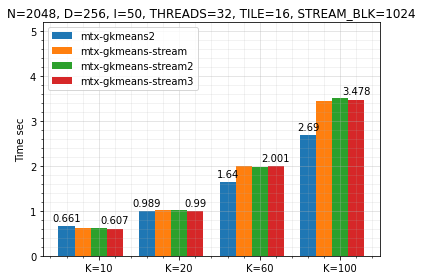

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['K=10', 'K=20', 'K=60', 'K=100']
gkmeans2 = [0.661, 0.989, 1.640, 2.690]
stream = [0.624, 1.012, 1.996, 3.458]
stream2 = [0.625, 1.014, 1.982, 3.522]
stream3 = [0.607, 0.990, 2.001, 3.478]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects2 = ax.bar(x - width * 2, gkmeans2, width, label='mtx-gkmeans2')
rects1 = ax.bar(x - width, stream, width, label='mtx-gkmeans-stream')
rects3 = ax.bar(x, stream2, width, label='mtx-gkmeans-stream2')
rects4 = ax.bar(x + width, stream3, width, label='mtx-gkmeans-stream3')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time sec')
ax.set_title('N=2048, D=256, I=50, THREADS=32, TILE=16, STREAM_BLK=1024')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


#autolabel(rects1)
autolabel(rects2)
#autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
#plt.yscale('log')
plt.grid(which='major', alpha=.4)
plt.minorticks_on()
plt.grid(which='minor', alpha=.2)
plt.ylim(top=5.2)
#plt.ylim(top=1)

plt.show()

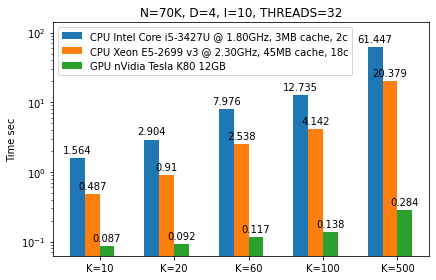

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['K=10', 'K=20', 'K=60', 'K=100', 'K=500']
i5_2 = [1.564, 2.904, 7.976, 12.735, 61.447]
xeon63 = [0.487, 0.910, 2.538, 4.142, 20.379]
k80 = [0.087, 0.092, 0.117, 0.138, 0.284]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width - width/2, i5_2, width, label='CPU Intel Core i5-3427U @ 1.80GHz, 3MB cache, 2c')
rects2 = ax.bar(x - width/2, xeon63, width, label='CPU Xeon E5-2699 v3 @ 2.30GHz, 45MB cache, 18c')
rects3 = ax.bar(x + width/2, k80, width, label='GPU nVidia Tesla K80 12GB')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time sec')
ax.set_title('N=70K, D=4, I=10, THREADS=32')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.yscale('log')
plt.ylim(top=140)
#plt.ylim(top=70)

plt.show()